这个代码调查了为什么bestCQ具有名义高CQ，但是实际非线性能力和任务表现较差的原因

原文件名：test_bestCQ_nomemory.ipynb

In [2]:
# import necessary libraries
import os
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import pickle



from pathlib import Path


CANDIDATES = [
    
    Path(r"C:\Users\tom\Desktop\Repository"),
    Path(r"C:\Users\Chen\Desktop\Repository"),
    Path(r"/Users/vvvp./Desktop"),
]
searchpaths = [p for p in CANDIDATES if p.exists()]

#tuple of repos
repos = ('machine_learning_library',)





import sys
import os
# In Jupyter notebooks, __file__ is not defined. Use the current working directory instead.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import repo_tools
repo_tools.repos_path_finder(searchpaths, repos)
from spnc import spnc_anisotropy
import spnc_ml as ml
from deterministic_mask import fixed_seed_mask, max_sequences_mask

from single_node_res import single_node_reservoir
import ridge_regression as RR
from linear_layer import *
from mask import binary_mask
from utility import *
from NARMA10 import NARMA10
from datasets.load_TI46_digits import *
import datasets.load_TI46 as TI46
from sklearn.metrics import classification_report
from formal_Parameter_Dynamics_Preformance import *


In [3]:
# 构建储层对象
class ReservoirParams:
    def __init__(self, **kwargs):
            # Reservoir parameters 
            self.h = 0.4
            self.theta_H = 90
            self.k_s_0 = 0
            self.phi = 45
            self.beta_prime = 35.13826524755751

            # Network parameters 
            self.Nvirt = 50
            self.m0 = 0.005288612874870094
            self.bias = True
            self.Nwarmup = 0
            self.verbose_repr = False

            self.params = {
                'theta': 0.34142235979698393,
                'gamma': 0.069274461903986,
                'delay_feedback': 0,
                'Nvirt': self.Nvirt,
                'length_warmup': self.Nwarmup,
                'warmup_sample': self.Nwarmup * self.Nvirt,
                'voltage_noise': False,
                'seed_voltage_noise': 1234,
                'delta_V': 0.1,
                'johnson_noise': False,
                'seed_johnson_noise': 1234,
                'mean_johnson_noise': 0.0000,
                'std_johnson_noise': 0.00001,
                'thermal_noise': False,
                'seed_thermal_noise': 1234,
                'lambda_ou': 1.0,
                'sigma_ou': 0.1
        }

            for key in ['h', 'theta_H', 'k_s_0', 'phi', 'beta_prime', 'Nvirt', 'm0', 'bias', 'Nwarmup']:
                if key in kwargs:
                    setattr(self, key, kwargs[key])

            
            if 'params' in kwargs and isinstance(kwargs['params'], dict):
                self.params.update(kwargs['params'])

    
    def update_params(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            if key in self.params:
                self.params[key] = value
            if not hasattr(self, key) and key not in self.params:
                raise AttributeError(f"ReservoirParams has no attribute or param key '{key}'")
            
    def print_params(self, verbose=False):
        if not verbose:
            print(f"ReservoirParams(h={self.h}, beta_prime={self.beta_prime}, Nvirt={self.Nvirt})")
        else:
            print(f"ReservoirParams detailed info:")
            print(f"  h = {self.h}")
            print(f"  theta_H = {self.theta_H}")
            print(f"  k_s_0 = {self.k_s_0}")
            print(f"  phi = {self.phi}")
            print(f"  beta_prime = {self.beta_prime}")
            print(f"  Nvirt = {self.Nvirt}")
            print(f"  m0 = {self.m0}")
            print(f"  bias = {self.bias}")
            print("  params dictionary:")
            for k, v in self.params.items():
                print(f"    {k}: {v}")

In [3]:
def MSE(pred, desired):
    return np.mean(np.square(np.subtract(pred, desired)))

def NRMSE(pred, y_test, spacer=0.001):
    return np.sqrt(MSE(pred, y_test) / np.var(y_test))

In [4]:
def generate_signal(I,washout = 50,seed=1234):
    '''
    Generate a i.i.d. signal sequence with a [-1,1] range
    '''
    if seed is not None:
        np.random.seed(seed)
        
    signal_sequence = np.random.uniform(-1,1,size = I)

    washed_signal = signal_sequence[washout:]

    # Convert to 2D array
    washed_signal = washed_signal.reshape(-1,1)

    # print(np.shape(washed_signal))

    return washed_signal

def RidgeRegression(states, target, l, bias=True):
    # Ensure numpy
    if torch.is_tensor(states):
        states = states.detach().cpu().numpy()
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()
    if bias==True:
        # Add bias to states
        bias = np.ones((len(states), 1))
        states = np.concatenate((bias, states), axis=1)
    # Setup matrices from inputs
    M1 = np.matmul(states.transpose(), target) 
    M2 = np.matmul(states.transpose(), states)
    # Perform ridge regression
    weights = np.matmul(np.linalg.pinv(M2+l*np.identity(len(M2))), M1)
    return weights

def linear_MC(signal, states, splits=[0.2, 0.8], delays=50):
    # ensure flat input signal
    signal = np.asarray(signal).flatten()
    # generate target signal from delayed input signal
    shift = np.zeros((len(signal), delays))
    for i in range(len(signal)-delays):
        i += delays
        shift[i, :] = signal[i-delays:i]
    # split data
    wash, Ytrain, Ytest = np.split(shift, [int(len(signal)*splits[0]), int(len(signal)*splits[1])])
    wash, Xtrain, Xtest = np.split(states, [int(len(signal)*splits[0]), int(len(signal)*splits[1])])
    # sweep over range of hyperparameters gamma to find optimal MC
    bestMC = 0
    gammas = np.logspace(-10, 0, 11)
    for gamma in gammas:
        # Calculate weights
        weights = RidgeRegression(Xtrain, Ytrain, gamma, bias=False)
        # Predict test states
        prediction = np.matmul(Xtest, weights)
        # Loop over all delays k and evaluate MC_k
        MC_k = np.zeros(delays)
        for k in range(delays):
            # Take prediction and target for each delay
            pred = prediction[:, k]
            targ = Ytest[:, k]
            # Set up matrix to calculate covariance
            M = pred, targ
            # Calculate covariance
            coVarM = np.cov(M)
            # Take cov(xy) 
            coVar = coVarM[0,1]
            # Measure the variance of the signals
            outVar = np.var(pred)
            targVar = np.var(targ)
            # Calculate the total variance of the raw target and the specific
            # target
            totVar = outVar*targVar
            # If the covariance coefficient is greater than 0.1, treat as better
            # than random guessing and add to MC_k outputs
            if coVar**2/totVar > 0.1:
                MC_k[k] = coVar**2/totVar
        # Account for floating point errors in MC
        MC_k[MC_k>1] = 1
        # Sum memory capacity over all delays
        MC = sum(MC_k)
        # If best reported MC, save data
        if MC > bestMC:
            bestMC = MC
    return bestMC

def RunSpnc(signal,Nin,Nout,Nvirt,m0,transform, params,**kwargs):
    '''
    Run a reservoir computer with the signal sequence
    '''
    snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res=transform)

    fixed_mask = kwargs.get('fixed_mask', False)
    if fixed_mask==True:
        # print("Deterministic mask will be used")
        seed_mask = kwargs.get('seed_mask', 1234)
        if seed_mask>=0:
            # print(seed_mask)
            snr.M = fixed_seed_mask(Nin, Nvirt, m0, seed=seed_mask)
        else:
            # print("Max_sequences mask will be used")
            snr.M = max_sequences_mask(Nin, Nvirt, m0)
    
    # Run
    S,_ = snr.transform(signal,params)
    
    return S
    
def evaluate_MC(reservoir_params, signal_len = 550, **kwargs):

    signal = generate_signal(signal_len, seed=kwargs.get('seed', 1234))
    # 打印signal的前10个元素


    spn = spnc_anisotropy(
        reservoir_params.h,
        reservoir_params.theta_H,
        reservoir_params.k_s_0,
        reservoir_params.phi,
        reservoir_params.beta_prime,
        restart=True
    )

    transform = spn.gen_signal_slow_delayed_feedback

    Output = RunSpnc(
        signal,
        1,                 
        1,       
        reservoir_params.Nvirt,
        reservoir_params.m0,
        transform,
        reservoir_params.params,
        fixed_mask=True,
        seed_mask=1234
    )


    MC = linear_MC(signal, Output, splits=[0.2,0.6], delays=10)

    return MC

In [4]:
def gen_KR_GR_input(Nreadouts, Nwash=10, seed=1234):
    # set seed
    np.random.seed(seed)
    # generate KR inputs
    KR_inputs = np.random.ranf((Nreadouts, Nwash))
    # 打印KR_inputs
    # print('KR_inputs',KR_inputs)
    # print('shape of KR_inputs',np.shape(KR_inputs))

    GR_inputs = np.tile(np.random.ranf((10)), (Nreadouts,1))
    # print('GR_inputs',GR_inputs)
    # print('shape of GR_inputs',np.shape(GR_inputs))

    all_inputs = np.concatenate((KR_inputs, GR_inputs), axis=1)
    # 打印all_inputs的前10个元素
    # print('all_inputs',all_inputs)
    # print('shape of all_inputs',np.shape(all_inputs))
    return all_inputs


def Evaluate_KR_GR(states, Nreadouts, threshold=0.1):
    GR_states = states[:,-1,:]
    # print('GR_states',GR_states)
    # print('shape of GR_states',np.shape(GR_states))
    '''
    Change the last 7 columns to GR states, the rest are KR states
    '''
    KR_states = states[:,-11,:]
    # print('KR_states',KR_states)
    # print('shape of KR_states',np.shape(KR_states)) 
    
    uGR, sGR, vGR = np.linalg.svd(GR_states)
    uKR, sKR, vKR = np.linalg.svd(KR_states)
    KR = 0
    GR = 0
    for i in range(Nreadouts):
        if sGR[i]>threshold:
            GR += 1
        if sKR[i]>threshold:
            KR += 1
    return KR, GR, GR_states, KR_states,sGR,sKR

# ------------------------ Reservoir ----------------------------


In [ ]:
def evaluate_KRandGR(reservoir_params, Nreadouts=50, Nwash=10, **kwargs):
    
    Nreadouts= reservoir_params.Nvirt

    inputs = gen_KR_GR_input(Nreadouts, Nwash, seed=1234)   # <--- 用Nreadouts
    outputs = []
    for input_row in inputs:
        input_row = input_row.reshape(-1, 1)
        spn = spnc_anisotropy(reservoir_params.h, reservoir_params.theta_H,
                              reservoir_params.k_s_0, reservoir_params.phi,
                              reservoir_params.beta_prime, restart=True)
        transforms = spn.gen_signal_slow_delayed_feedback
        output = RunSpnc(input_row, 1, 1, reservoir_params.Nvirt,
                         reservoir_params.m0, transforms, reservoir_params.params, fixed_mask=True, seed_mask=1234)
        outputs.append(output)
    States = np.stack(outputs, axis=0)
    Normalized_States = States/np.amax(States)
    use_normalized = kwargs.get('use_normalized', False)
    if use_normalized:
        States = Normalized_States
    else:
        States = States 
    KR, GR, GR_states, KR_states,sGR,sKR = Evaluate_KR_GR(States, Nreadouts, threshold=0.001)  # <--- 用Nreadouts
    return KR, GR, GR_states, KR_states,sGR,sKR, outputs, States, Normalized_States


In [6]:
def eva_narma10(reservoir_params: ReservoirParams, 
                        Ntrain: int = 2000, Ntest: int = 1000, seed_NARMA: int = 1234, return_all: bool = True):
        """评估NARMA-10任务"""

        # 创建储层
        spn = spnc_anisotropy(
            h=reservoir_params.h,
            theta_H=reservoir_params.theta_H,
            k_s=reservoir_params.k_s_0,
            phi=reservoir_params.phi,
            beta_prime=reservoir_params.beta_prime,
            restart=True
        )

        transform = spn.gen_signal_slow_delayed_feedback
        
        # 运行NARMA-10任务
        (y_test,pred, x_train, y_train, x_test, y_test, S_train, S_test, J_train, J_test, M, W) = ml.spnc_narma10_test(
            Ntrain,
            Ntest,
            reservoir_params.Nvirt,
            reservoir_params.m0,
            reservoir_params.bias,
            transform,
            reservoir_params.params,
            seed_NARMA=seed_NARMA,
            fixed_mask=True,
            seed_mask=1234,
            return_all=True
        )
        
        # 使用dict来返回所有结果
        results = {
            'y_test': y_test,
            'pred': pred,
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test,
            'S_train': S_train,
            'S_test': S_test,
            'J_train': J_train,
            'J_test': J_test,
            'M': M,
            'W': W
        }
        
        return results

In [ ]:
def eva_ti46(reservoir_params: ReservoirParams, 
                    speakers: ['f1','f2','f3','f4','f5']) -> float:
    """评估TI46任务"""
    
    # 创建储层
    spn = spnc_anisotropy(
        h=reservoir_params.h,
        theta_H=reservoir_params.theta_H,
        k_s=reservoir_params.k_s_0,
        phi=reservoir_params.phi,
        beta_prime=reservoir_params.beta_prime,
        restart=True
    )

    transform = spn.gen_signal_slow_delayed_feedback
    
    # 运行TI46任务
    accuracy = ml.spnc_TI46(
        speakers,
        reservoir_params.Nvirt,
        reservoir_params.m0,
        reservoir_params.bias,
        transform,
        reservoir_params.params)
    
    return accuracy


### 以下cell是用来评估是否bestCQ对于任意namra10输入序列的反馈都是一样的

In [9]:
params_bestCQ = ReservoirParams(
        h=0.4, m0=0.006937322149792008, Nvirt=50, beta_prime=27.251620432439488,
        params={'theta': 0.01, 'gamma': 0.3663969812988086, 'Nvirt': 50}
    )

In [10]:
y_test, pred_1234 = eva_narma10(params_bestCQ, Ntrain=2000, Ntest=1000, seed_NARMA=1234)











Seed Training: 1234
len(x_train): 2000
error with zero =  0.025590136678639137
0.01224755838850576 1.000013157854191


In [15]:
# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE

# seed是1000以内的随机数
seed_NARMA = np.random.randint(0, 1000, 3)
params_dict = {}

# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE
for idx, i in enumerate(seed_NARMA):
    params = ReservoirParams(
        h=0.4, m0=0.006937322149792008, Nvirt=50, beta_prime=27.251620432439488,
        params={'theta': 0.01, 'gamma': 0.3663969812988086, 'Nvirt': 50}
    )

    y_test, pred = eva_narma10(params, Ntrain=2000, Ntest=1000, seed_NARMA=i)
    nrmse = NRMSE(pred,y_test)
    params_dict[idx] = {
        'seed_NARMA': i,
        'nrmse': nrmse,
        'y_test': y_test,
        'pred': pred
    }
    print(f"idx: {idx}, seed_NARMA: {i}, NRMSE: {nrmse}")








Seed Training: 1234
len(x_train): 2000
error with zero =  5.26428902232998
0.011002367355309656 1.0060783138695921
idx: 0, seed_NARMA: 260, NRMSE: 42.41701325173466
Seed Training: 1234
len(x_train): 2000
error with zero =  2.0590481326243655
0.01369482168111302 1.0019076301442738
idx: 1, seed_NARMA: 464, NRMSE: 511.1831438298664
Seed Training: 1234
len(x_train): 2000
error with zero =  19.10735517398901
0.01015276283533789 1.0001841787472225
idx: 2, seed_NARMA: 743, NRMSE: 231.25096056969974


### 画出trajectory图来看看

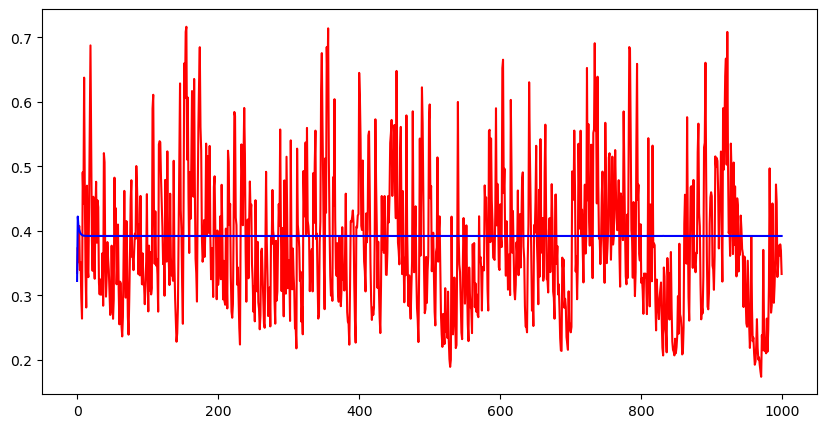

In [17]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict[0]['y_test'], color='red')
plt.plot(params_dict[0]['pred'], color='blue')
plt.show()  

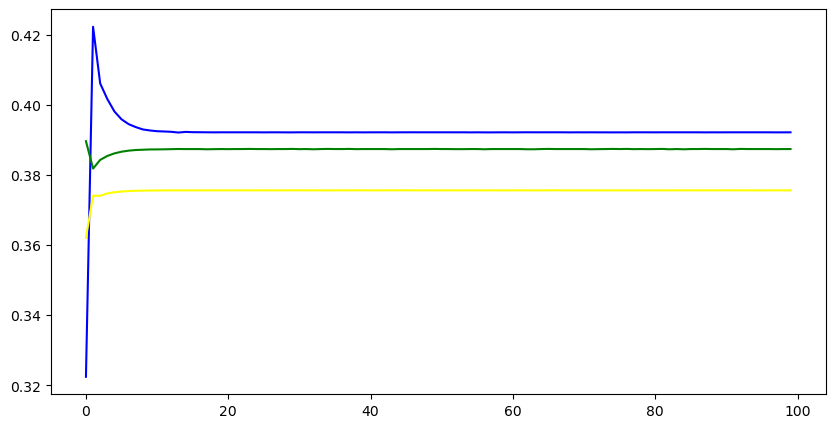

In [19]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict[0]['pred'][:100], color='blue')
plt.plot(params_dict[1]['pred'][:100], color='green')
plt.plot(params_dict[2]['pred'][:100], color='yellow')
plt.show()  

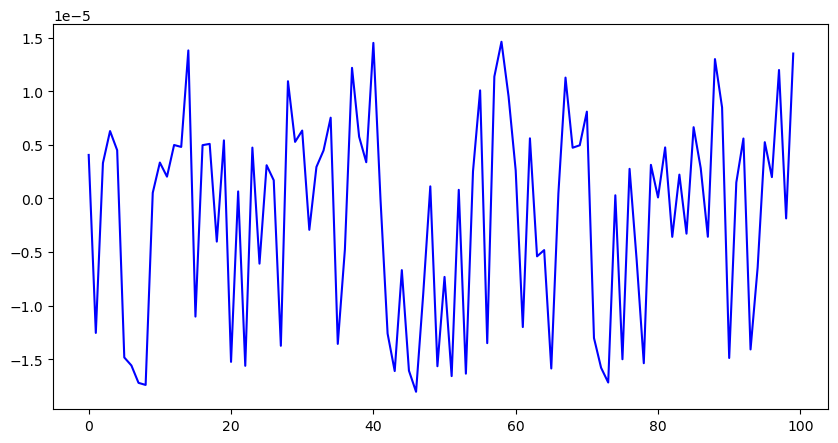

In [29]:
average = np.mean(params_dict[0]['pred'][100:])
difference = params_dict[0]['pred'] - average

plt.figure(figsize=(10, 5))
plt.plot(difference[100:200], color='blue')
plt.show()  










### 测试bestMC作为对比

In [20]:
params_bestMC = ReservoirParams(
        h=0.4, m0=0.008, Nvirt=50, beta_prime=	50.0,
        params={'theta': 0.1564938388583194, 'gamma': 0.04608425844940916, 'Nvirt': 50}
    )

y_test_bestMC, pred_bestMC_1234 = eva_narma10(params_bestMC, Ntrain=2000, Ntest=1000, seed_NARMA=1234)

Seed Training: 1234
len(x_train): 2000
error with zero =  0.004568546087762927
0.011018730520634875 0.9485205315352864


In [21]:
# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE

# seed是1000以内的随机数
seed_NARMA = np.random.randint(0, 1000, 3)
params_dict_MC = {}

# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE
for idx, i in enumerate(seed_NARMA):
    params = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=50, beta_prime=	50.0,
            params={'theta': 0.1564938388583194, 'gamma': 0.04608425844940916, 'Nvirt': 50}
        )

    y_test, pred = eva_narma10(params, Ntrain=2000, Ntest=1000, seed_NARMA=i)
    nrmse = NRMSE(pred,y_test)
    params_dict_MC[idx] = {
        'seed_NARMA': i,
        'nrmse': nrmse,
        'y_test': y_test,
        'pred': pred
    }
    print(f"idx: {idx}, seed_NARMA: {i}, NRMSE: {nrmse}")

Seed Training: 1234
len(x_train): 2000
error with zero =  0.004755069542823838
0.007168379906776746 0.7878163800176976
idx: 0, seed_NARMA: 907, NRMSE: 0.7878163800176976
Seed Training: 1234
len(x_train): 2000
error with zero =  0.004062858107774707
0.008025066737511879 0.7702494462236094
idx: 1, seed_NARMA: 204, NRMSE: 0.7702494462236094
Seed Training: 1234
len(x_train): 2000
error with zero =  0.006131437582124847
0.008893885864580217 0.8180110846429584
idx: 2, seed_NARMA: 570, NRMSE: 0.8180110846429584


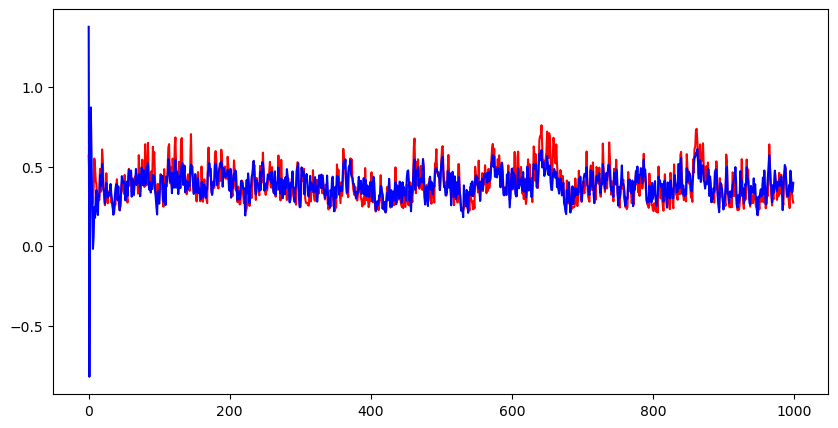

In [22]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_MC[0]['y_test'], color='red')
plt.plot(params_dict_MC[0]['pred'], color='blue')
plt.show()  

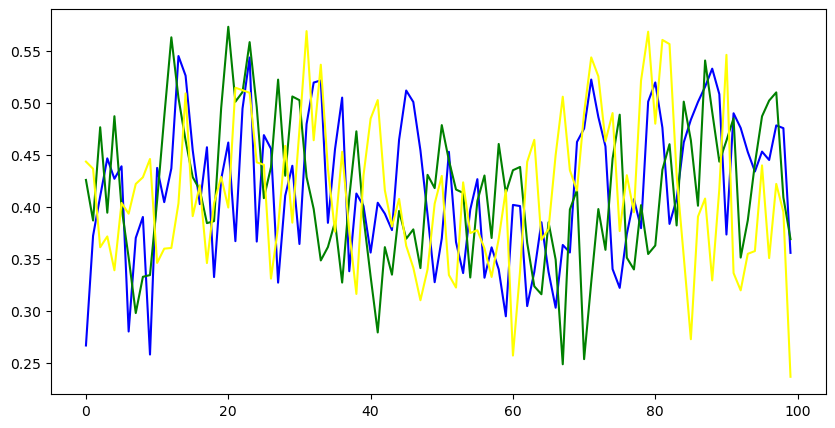

In [23]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_MC[0]['pred'][100:200], color='blue')
plt.plot(params_dict_MC[1]['pred'][100:200], color='green')
plt.plot(params_dict_MC[2]['pred'][100:200], color='yellow')
plt.show()  

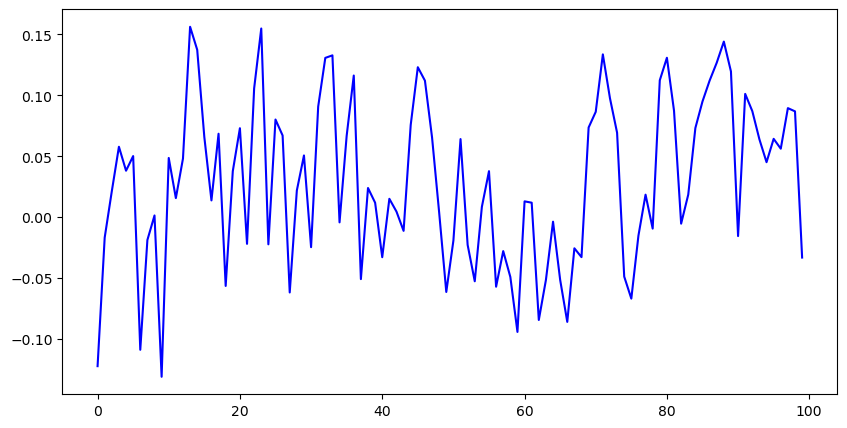

In [31]:
average_MC = np.mean(params_dict_MC[0]['pred'][100:])
difference_MC = params_dict_MC[0]['pred'] - average_MC

plt.figure(figsize=(10, 5))
plt.plot(difference_MC[100:200], color='blue')
plt.show()  


### 测试下12号

In [32]:
# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE

# seed是1000以内的随机数
seed_NARMA = np.random.randint(0, 1000, 3)
params_dict_121 = {}

# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE
for idx, i in enumerate(seed_NARMA):
    params = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=50, beta_prime=	50.0,
            params={'theta': 0.01, 'gamma': 0.1293026614808925, 'Nvirt': 50}
        )

    y_test, pred = eva_narma10(params, Ntrain=2000, Ntest=1000, seed_NARMA=i)
    nrmse = NRMSE(pred,y_test)
    params_dict_121[idx] = {
        'seed_NARMA': i,
        'nrmse': nrmse,
        'y_test': y_test,
        'pred': pred
    }
    print(f"idx: {idx}, seed_NARMA: {i}, NRMSE: {nrmse}")

Seed Training: 1234
len(x_train): 2000
error with zero =  0.01297899684629399
0.010506358810666382 1.009313808227264
idx: 0, seed_NARMA: 877, NRMSE: 1.009313808227264
Seed Training: 1234
len(x_train): 2000
error with zero =  0.014693424606622952
0.011745158840569349 1.0022019403919467
idx: 1, seed_NARMA: 529, NRMSE: 1.0022019403919467
Seed Training: 1234
len(x_train): 2000
error with zero =  0.02072509060019548


KeyboardInterrupt: 

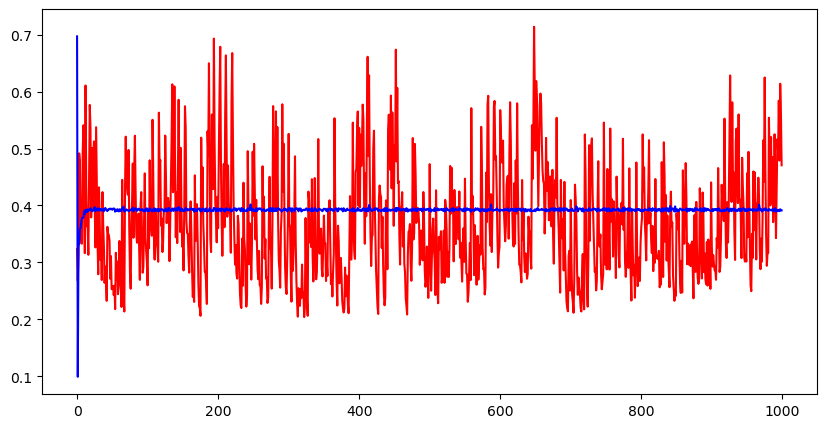

In [ ]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_121[0]['y_test'], color='red')
plt.plot(params_dict_121[0]['pred'], color='blue')
plt.show() 

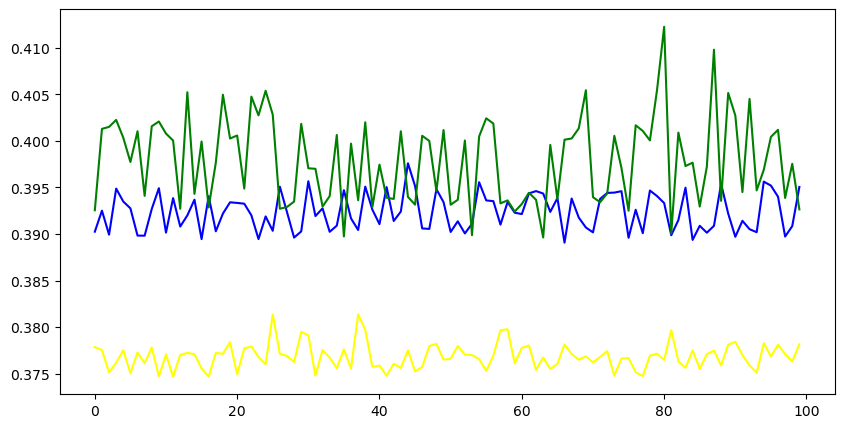

In [ ]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_121[0]['pred'][100:200], color='blue')
plt.plot(params_dict_121[1]['pred'][100:200], color='green')
plt.plot(params_dict_121[2]['pred'][100:200], color='yellow')
plt.show()

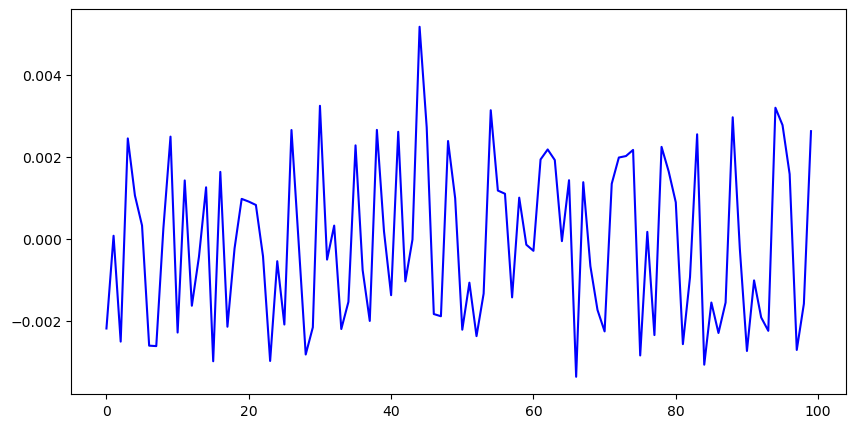

In [ ]:
average_121 = np.mean(params_dict_121[0]['pred'][100:])
difference_121 = params_dict_121[0]['pred'] - average_121

plt.figure(figsize=(10, 5))
plt.plot(difference_121[100:200], color='blue')
plt.show()  


#### 测试下cq_mc_pareto_beta50中的no.33

In [41]:
# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE

# seed是1000以内的随机数
seed_NARMA = np.random.randint(0, 1000, 3)
params_dict_beta50_33 = {}

# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE
for idx, i in enumerate(seed_NARMA):
    params = ReservoirParams(
            h=0.4, m0=0.17389499595223099, Nvirt=50, beta_prime=	50.0,
            params={'theta': 0.2, 'gamma': 0.09431886362115637, 'Nvirt': 50}
        )

    y_test, pred = eva_narma10(params, Ntrain=2000, Ntest=1000, seed_NARMA=i)
    nrmse = NRMSE(pred,y_test)
    params_dict_beta50_33[idx] = {
        'seed_NARMA': i,
        'nrmse': nrmse,
        'y_test': y_test,
        'pred': pred
    }
    print(f"idx: {idx}, seed_NARMA: {i}, NRMSE: {nrmse}")

Seed Training: 1234
len(x_train): 2000
error with zero =  0.010710454243955387
0.024996767954012403 1.4322463657106195
idx: 0, seed_NARMA: 391, NRMSE: 1.4322463657106195
Seed Training: 1234
len(x_train): 2000
error with zero =  0.007243323283829389
0.019904030748374223 1.3535247588908323
idx: 1, seed_NARMA: 242, NRMSE: 1.3535247588908323
Seed Training: 1234
len(x_train): 2000
error with zero =  0.008096186566083184
0.0192252573098109 1.3185625319783616
idx: 2, seed_NARMA: 294, NRMSE: 1.3185625319783616


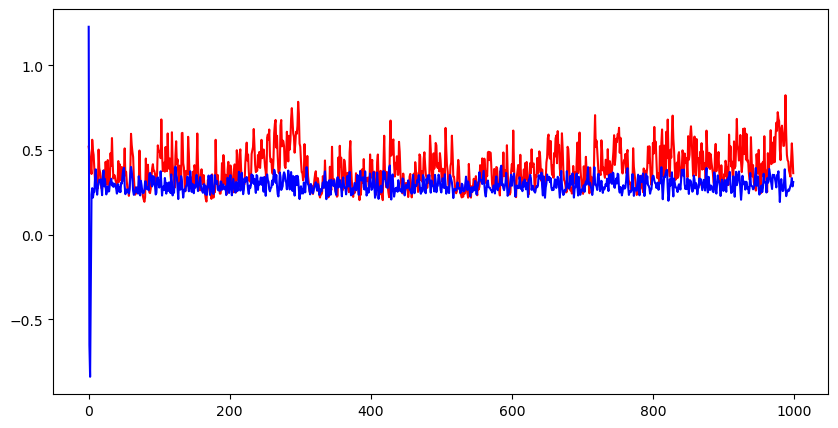

In [43]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_beta50_33[0]['y_test'], color='red')
plt.plot(params_dict_beta50_33[0]['pred'], color='blue')
plt.show() 

#### 测试下no.267

In [29]:
# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE

# seed是1000以内的随机数
seed_NARMA = np.random.randint(0, 1000, 3)
params_dict_beta50_267 = {}

# 创建一个loop，循环不同的seed_NARMA，并计算NRMSE
for idx, i in enumerate(seed_NARMA):
    params = ReservoirParams(
            h=0.4, m0=0.05165540820180517, Nvirt=50, beta_prime=	50.0,
            params={'theta': 0.2, 'gamma': 0.04802979116381437, 'Nvirt': 50}
        )

    y_test, pred = eva_narma10(params, Ntrain=2000, Ntest=1000, seed_NARMA=i)
    nrmse = NRMSE(pred,y_test)
    params_dict_beta50_267[idx] = {
        'seed_NARMA': i,
        'nrmse': nrmse,
        'y_test': y_test,
        'pred': pred
    }
    print(f"idx: {idx}, seed_NARMA: {i}, NRMSE: {nrmse}")

NameError: name 'spnc_narma10' is not defined

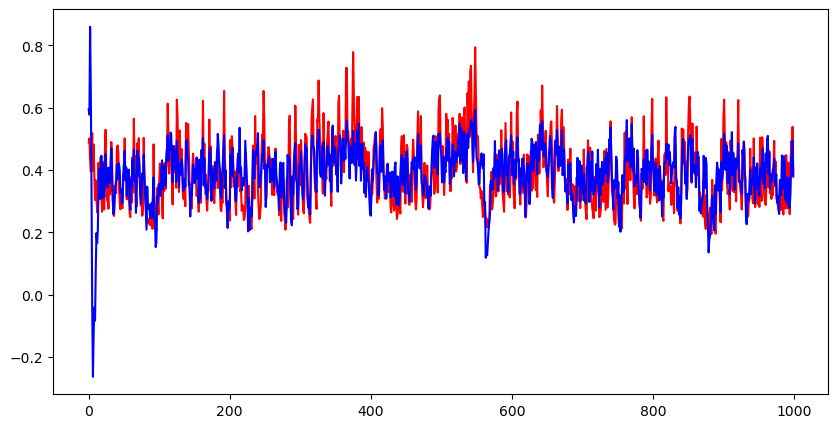

In [ ]:
plt.figure(figsize=(10, 5))

# params_dict中第一个的y_test和pred
plt.plot(params_dict_beta50_267[0]['y_test'], color='red')
plt.plot(params_dict_beta50_267[0]['pred'], color='blue')
plt.show() 

02/09/25: 经过与Tom的讨论，我们已经也可以确定'highCQ'与'task performance' 的错配可能来自于CQ的计算。

假设：在Ian的代码中，我选择了不合适的参数导致CQ的计算值有误。
验证：更加细致地理解CQ的计算。

(200, 20)


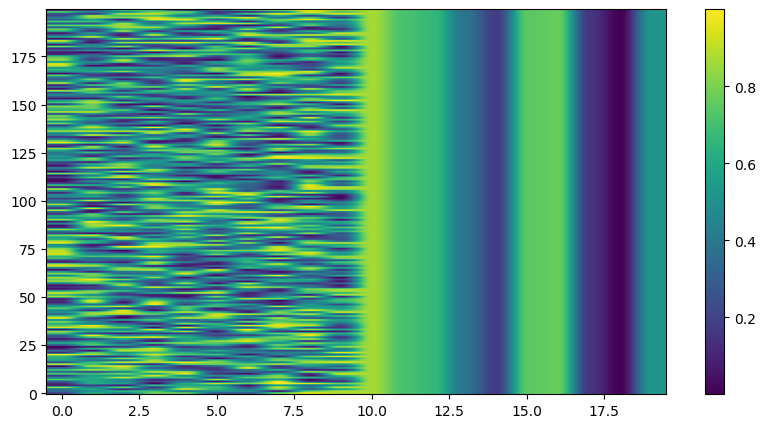

In [24]:
# 打印all_inputs
all_inputs = gen_KR_GR_input(200, Nwash=10, seed=1234)

print(np.shape(all_inputs))

# 使用heatmap来可视化
# 画一个原始热力图
plt.figure(figsize=(10, 5))
plt.imshow(all_inputs, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [9]:
# 直观地对比bestMC和bestCQ的差异
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=200, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 200}
        )

params_bestMC = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=200, beta_prime=	50.0,
            params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 200}
        )  
print('#########################')
print('bestCQ')       
KR_bestCQ, GR_bestCQ, GR_states_bestCQ, KR_states_bestCQ,sGR_bestCQ,sKR_bestCQ, outputs_bestCQ, States_bestCQ, Normalized_States_bestCQ = evaluate_KRandGR(params_bestCQ, threshold=0.001)
print('KR_bestCQ, GR_bestCQ', KR_bestCQ, GR_bestCQ)
print('#########################')

print('#########################')
print('bestMC')
KR_bestMC, GR_bestMC, GR_states_bestMC, KR_states_bestMC,sGR_bestMC,sKR_bestMC, outputs_bestMC, States_bestMC, Normalized_States_bestMC= evaluate_KRandGR(params_bestMC, threshold=0.001)
print('KR_bestMC, GR_bestMC', KR_bestMC, GR_bestMC)
print('#########################')





#########################
bestCQ
KR_bestCQ, GR_bestCQ 65 1
#########################
#########################
bestMC
KR_bestMC, GR_bestMC 35 6
#########################


(200, 20, 200)


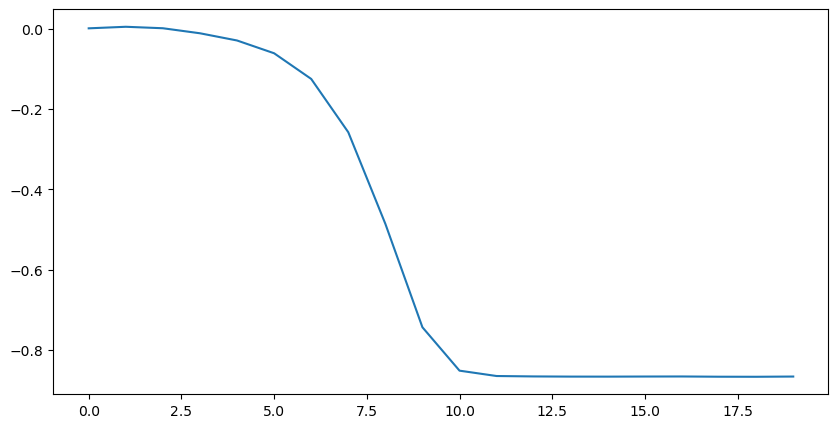

In [23]:
print(np.shape(outputs_bestCQ))

# 用热力图来展示outputs_bestCQ中的元素
plt.figure(figsize=(10, 5))
plt.plot(outputs_bestCQ[20][:,1])
plt.show()


shape of outputs_bestCQ (200, 20, 200)
(20, 200)
max of outputs_bestCQ_array 0.005080107141475998
min of outputs_bestCQ_array -0.867927831808759
max of outputs_bestMC_array 0.15819706530320526
min of outputs_bestMC_array -0.17288046298322818


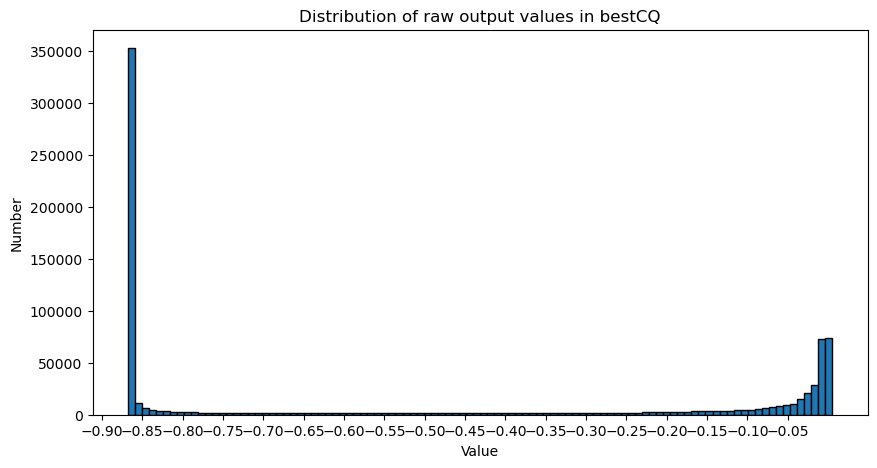

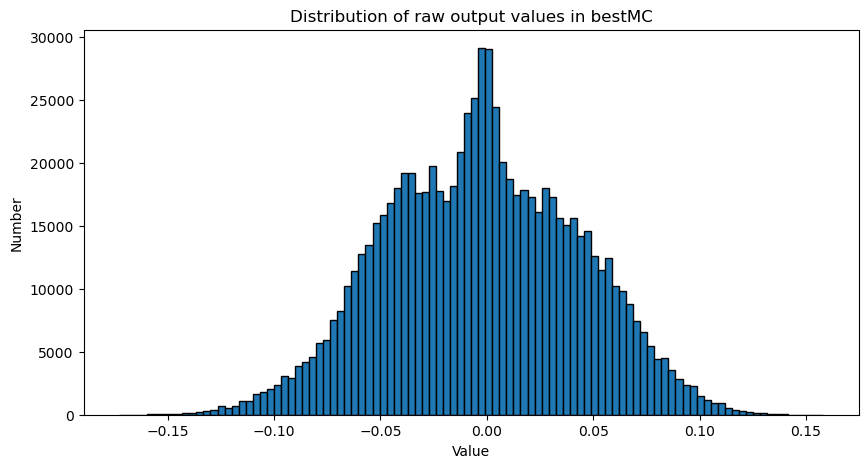

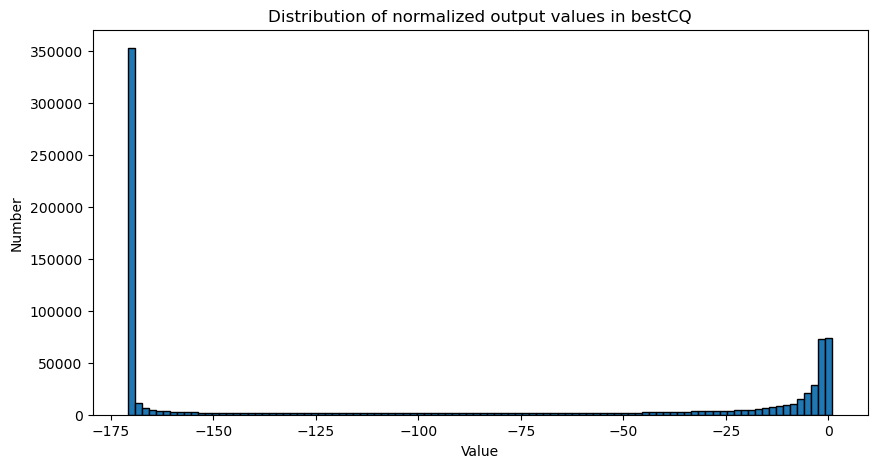

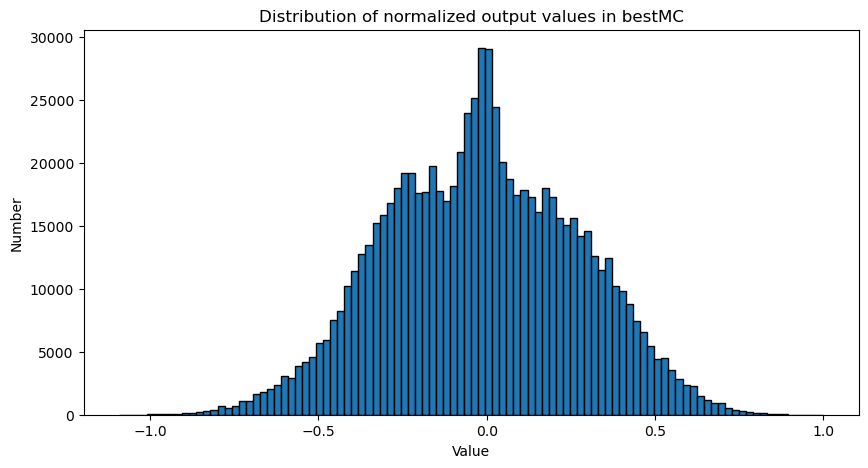

In [25]:
print('shape of outputs_bestCQ',np.shape(outputs_bestCQ))
print(np.shape(outputs_bestCQ[1]))

# 我想了解outputs_bestCQ中的元素数值分布，请用柱状图来表示元素的数值分布
# 将list转成numpy数组
outputs_bestCQ_array = np.array(outputs_bestCQ)
outputs_bestMC_array = np.array(outputs_bestMC)

# 打印出outputs_bestCQ_array的最大值和最小值
print('max of outputs_bestCQ_array',np.max(outputs_bestCQ_array))
print('min of outputs_bestCQ_array',np.min(outputs_bestCQ_array))

# 打印出outputs_bestMC_array的最大值和最小值
print('max of outputs_bestMC_array',np.max(outputs_bestMC_array))
print('min of outputs_bestMC_array',np.min(outputs_bestMC_array))



plt.figure(figsize=(10, 5))
plt.hist(outputs_bestCQ_array.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
# x轴的刻度尺再细一点
plt.xticks(np.arange(-0.9, 0, 0.05))
plt.title('Distribution of raw output values in bestCQ')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(outputs_bestMC_array.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of raw output values in bestMC')
plt.show()


# States_bestCQ的分布
plt.figure(figsize=(10, 5))
plt.hist(Normalized_States_bestCQ.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in bestCQ')
plt.show()

# States_bestMC的分布
plt.figure(figsize=(10, 5))
plt.hist(Normalized_States_bestMC.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in bestMC')
plt.show()





我可以打印出KR和GR时刻储层的状态，来对比

GR_states_bestCQ [[-170.7557723  -170.57963811 -170.58230644 ... -170.56190265
  -170.73839685 -170.73607941]
 [-170.75577231 -170.57963812 -170.58230645 ... -170.56190265
  -170.73839685 -170.73607941]
 [-170.75577231 -170.57963812 -170.58230644 ... -170.56190265
  -170.73839685 -170.73607941]
 ...
 [-170.7557723  -170.57963811 -170.58230644 ... -170.56190265
  -170.73839685 -170.73607941]
 [-170.75577232 -170.57963813 -170.58230646 ... -170.56190265
  -170.73839685 -170.73607941]
 [-170.7557725  -170.5796383  -170.58230663 ... -170.56190267
  -170.73839687 -170.73607943]]
shape of GR_states_bestCQ (200, 200)


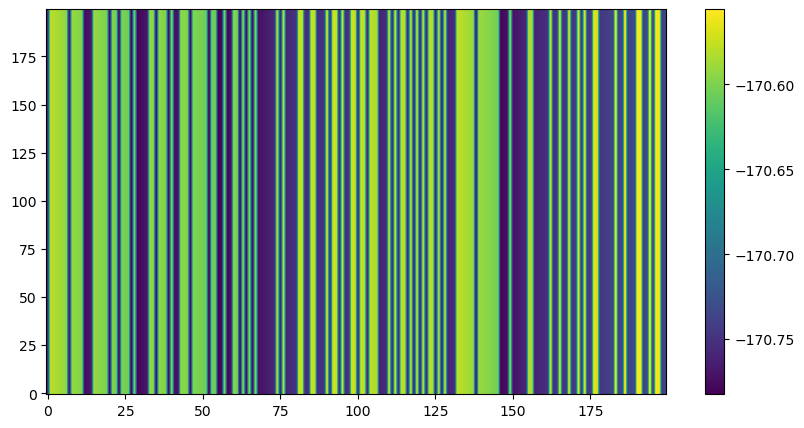

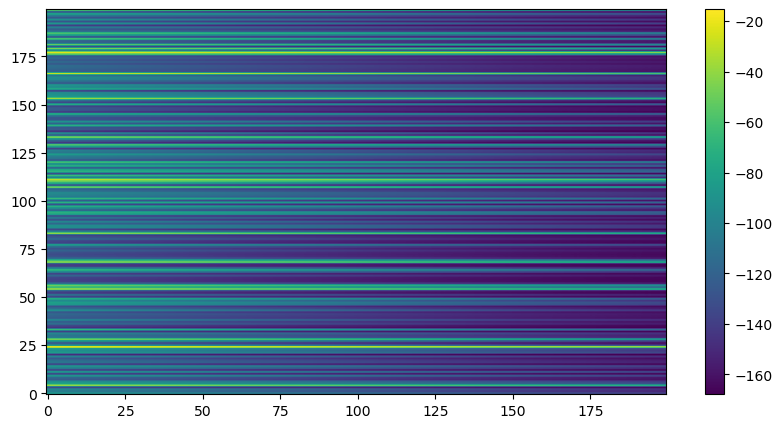

In [32]:
print('GR_states_bestCQ',GR_states_bestCQ)
print('shape of GR_states_bestCQ',np.shape(GR_states_bestCQ))

# 画一个原始热力图
plt.figure(figsize=(10, 5))
plt.imshow(GR_states_bestCQ, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(KR_states_bestCQ, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()




GR_states_bestMC [[0.35481439 0.28943896 0.22419118 ... 0.1885754  0.25107323 0.3111754 ]
 [0.35686908 0.29122725 0.22569681 ... 0.19100693 0.25343504 0.31345143]
 [0.35483484 0.28890301 0.2230895  ... 0.19130331 0.25352978 0.31333885]
 ...
 [0.35379709 0.28850043 0.22333958 ... 0.18764692 0.25015098 0.31026555]
 [0.35669669 0.2910323  0.22547942 ... 0.19102622 0.25343727 0.31343655]
 [0.35413727 0.28886247 0.22372121 ... 0.1877287  0.25025355 0.31038866]]
shape of GR_states_bestMC (200, 200)


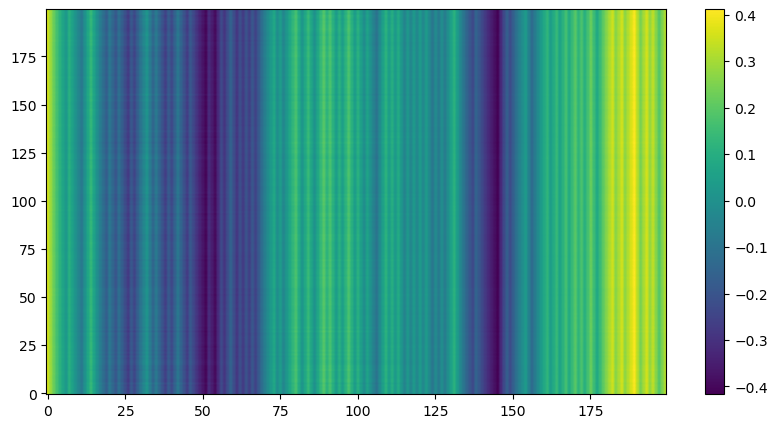

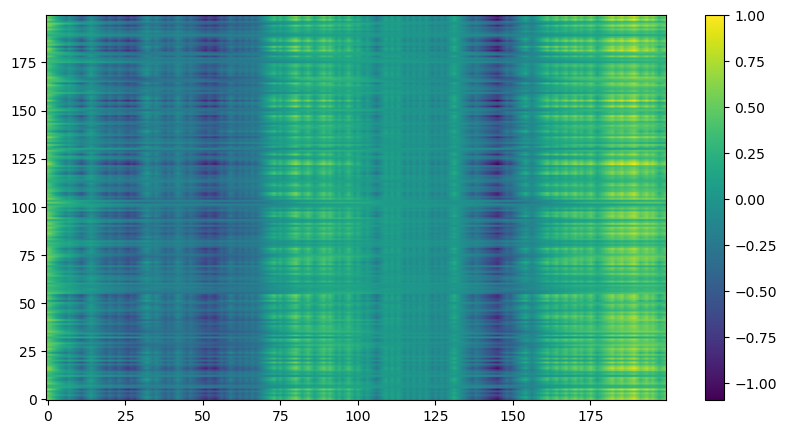

In [33]:
print('GR_states_bestMC',GR_states_bestMC)
print('shape of GR_states_bestMC',np.shape(GR_states_bestMC))

# 画一个原始热力图
plt.figure(figsize=(10, 5))
plt.imshow(GR_states_bestMC, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(KR_states_bestMC, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


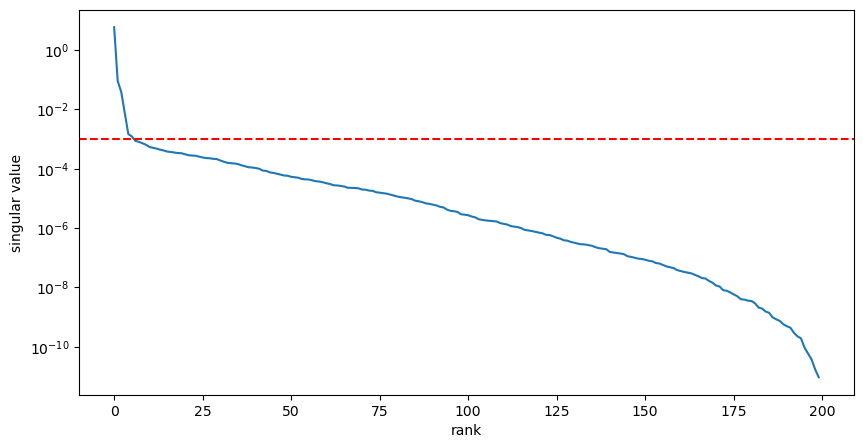

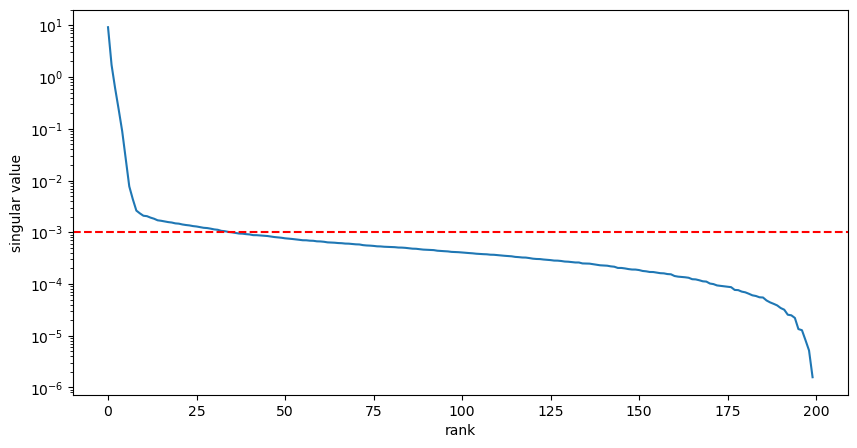

[5.82792049e+00 8.95069371e-02 3.84277891e-02 7.36674105e-03
 1.46450666e-03 1.20969743e-03 8.61312362e-04 7.95522140e-04
 7.14604304e-04 6.35097922e-04 5.32928458e-04 5.00875582e-04
 4.71099777e-04 4.33840875e-04 4.06942511e-04 3.74219328e-04
 3.63265320e-04 3.47864289e-04 3.33723109e-04 3.29753879e-04
 3.03366975e-04 2.81420315e-04 2.75884924e-04 2.70572265e-04
 2.52532345e-04 2.36510619e-04 2.26364342e-04 2.22583133e-04
 2.13305441e-04 2.08829034e-04 1.87230296e-04 1.70285024e-04
 1.56363283e-04 1.52119222e-04 1.48419342e-04 1.41971416e-04
 1.28536160e-04 1.19190257e-04 1.10690246e-04 1.08798810e-04
 1.04777082e-04 9.81915993e-05 8.58409627e-05 8.32800668e-05
 7.42234891e-05 7.14236197e-05 6.72273241e-05 6.27694979e-05
 5.84526216e-05 5.73144743e-05 5.28593171e-05 5.12294967e-05
 4.92930652e-05 4.46586895e-05 4.33467728e-05 4.27636404e-05
 3.99741151e-05 3.74969570e-05 3.65033247e-05 3.44362696e-05
 3.19289875e-05 3.02655930e-05 2.73983078e-05 2.70287840e-05
 2.58985694e-05 2.484959

In [27]:
#查看下sGR和sKR
plt.figure(figsize=(10, 5))
# 使用直方图
plt.plot(sGR_bestMC)
plt.yscale('log')
# 画一个辅助线
plt.axhline(y=0.001, color='red', linestyle='--')
plt.ylabel('singular value')
plt.xlabel('rank')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sKR_bestMC)
plt.yscale('log')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.ylabel('singular value')
plt.xlabel('rank')
plt.show()

print(sGR_bestMC)
print(sKR_bestMC)


如果不使用均一化，看看bestMC和bestCQ的KR和GR有什么改变？

In [10]:
# 直观地对比bestMC和bestCQ的差异
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=200, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 200}
        )

params_bestMC = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=200, beta_prime=	50.0,
            params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 200}
        )  
print('#########################')
print('bestCQ')       
KR_bestCQ_without_normalization, GR_bestCQ_without_normalization, GR_states_bestCQ_without_normalization, KR_states_bestCQ_without_normalization, outputs_bestCQ_without_normalization, States_bestCQ_without_normalization, _ = evaluate_KRandGR(params_bestCQ, threshold=0.1)
print('KR_bestCQ without normalization, GR_bestCQ without normalization', KR_bestCQ_without_normalization, GR_bestCQ_without_normalization)
print('#########################')

print('#########################')
print('bestMC')
KR_bestMC_without_normalization, GR_bestMC_without_normalization, GR_states_bestMC_without_normalization, KR_states_bestMC_without_normalization, outputs_bestMC_without_normalization, States_bestMC_without_normalization, _ = evaluate_KRandGR(params_bestMC, threshold=0.1)
print('KR_bestMC without normalization, GR_bestMC without normalization', KR_bestMC_without_normalization, GR_bestMC_without_normalization)
print('#########################')

#########################
bestCQ
KR_bestCQ without normalization, GR_bestCQ without normalization 3 1
#########################
#########################
bestMC
KR_bestMC without normalization, GR_bestMC without normalization 4 1
#########################


In [63]:
# 看看状态矩阵的数值是如何影响rank的个数的.
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=200, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 200}
        )
KR_test, GR_test, GR_states_test, KR_states_test, sGR_test, sKR_test, outputs_test, States_test, _ = evaluate_KRandGR(params_bestCQ, threshold=0.001,use_normalized=True)
print('KR_test, GR_test', KR_test, GR_test)


KR_test, GR_test 200 1


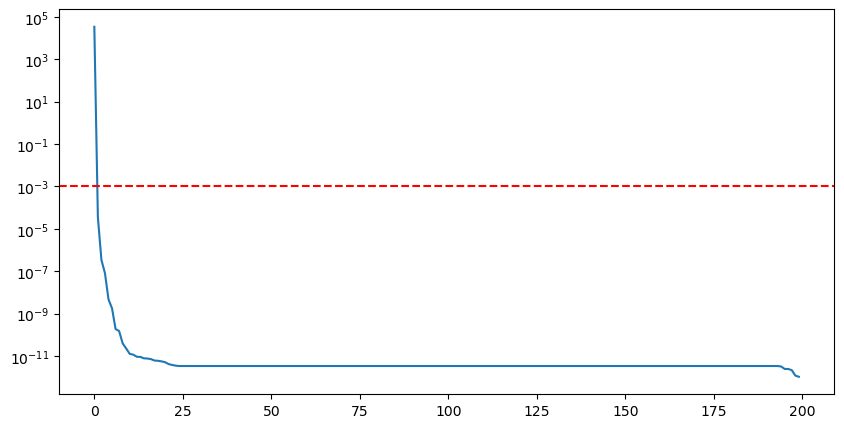

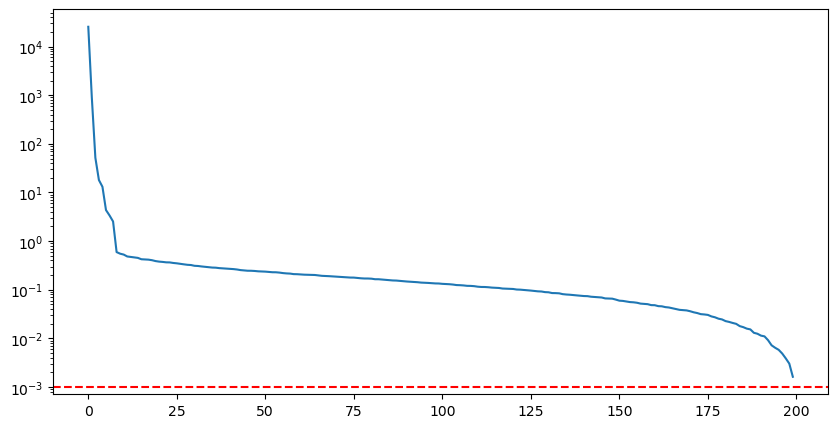

[3.41342351e+04 3.60179618e-05 3.44757125e-07 8.15317936e-08
 4.75550357e-09 1.78248150e-09 1.89171565e-10 1.51899955e-10
 3.98165075e-11 2.27898023e-11 1.27121367e-11 1.16601050e-11
 9.29623796e-12 9.16099711e-12 7.86665861e-12 7.67289568e-12
 7.18659540e-12 6.17232767e-12 6.00160962e-12 5.63483391e-12
 5.14317023e-12 4.18544614e-12 3.81745410e-12 3.53196503e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.40214934e-12 3.40214934e-12 3.40214934e-12
 3.40214934e-12 3.402149

In [64]:
#查看下sGR和sKR
plt.figure(figsize=(10, 5))
# 使用直方图
plt.plot(sGR_test)
plt.yscale('log')
# 画一个辅助线
plt.axhline(y=0.001, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sKR_test)
plt.yscale('log')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.show()

print(sGR_test)
print(sKR_test)


In [65]:
# 看看不使用normalised的话，sGR和sKR的数值会有变化吗？
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=200, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 200}
        )
KR_test_wn, GR_test_wn, GR_states_test_wn, KR_states_test_wn, sGR_test_wn, sKR_test_wn, outputs_test_wn, States_test_wn, _ = evaluate_KRandGR(params_bestCQ, threshold=0.001,use_normalized=False)
print('KR_test_wn, GR_test_wn', KR_test_wn, GR_test_wn)

KR_test_wn, GR_test_wn 65 1


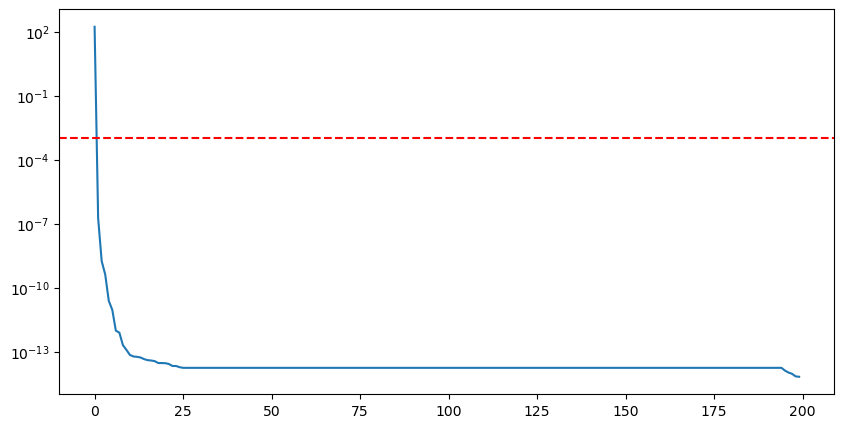

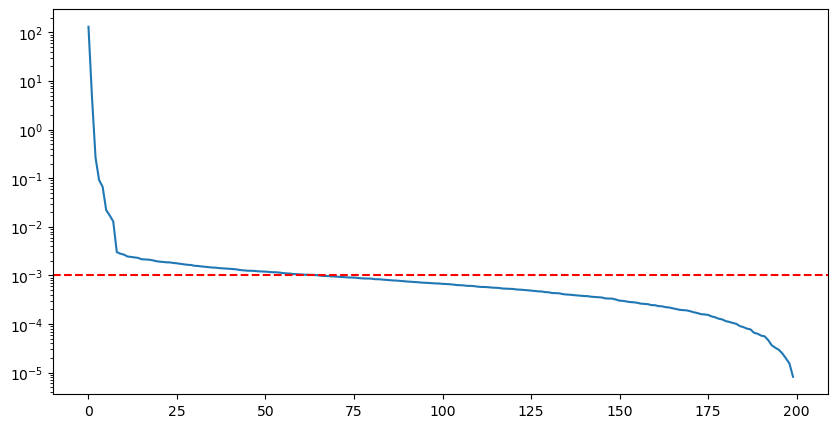

[1.73405572e+02 1.82975105e-07 1.75140277e-09 4.14192247e-10
 2.41580434e-11 9.05523950e-12 9.60775765e-13 7.70322489e-13
 2.01117746e-13 1.19112469e-13 6.87987676e-14 5.87991246e-14
 5.65969971e-14 5.26835132e-14 4.41553563e-14 3.95913272e-14
 3.80950384e-14 3.54414077e-14 2.89326977e-14 2.89240395e-14
 2.84852662e-14 2.61299992e-14 2.10911200e-14 2.10785426e-14
 1.85361172e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.72832832e-14 1.72832832e-14 1.72832832e-14
 1.72832832e-14 1.728328

In [ ]:
#查看下sGR和sKR
plt.figure(figsize=(10, 5))
# 使用直方图
plt.plot(sGR_test_wn)
plt.yscale('log')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.ylabel('singular value')
plt.xlabel('rank')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sKR_test_wn)
plt.yscale('log')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.show()

print(sGR_test_wn)
print(sKR_test_wn)

In [26]:
# 直观地比较两个sGR和sKR
plt.figure(figsize=(10, 5))
plt.plot(sGR_test_wn, label='sGR without normalization')
plt.plot(sGR_test, label='sGR with normalization')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('rank')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sKR_test_wn, label='sKR without normalization')
plt.plot(sKR_test, label='sKR with normalization')
plt.axhline(y=0.001, color='red', linestyle='--')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('rank')
plt.legend()
plt.show()


NameError: name 'sGR_test_wn' is not defined

<Figure size 1000x500 with 0 Axes>

那我们看看，如果input是一个随机噪声，那么两个储层的transform分别是怎么样的？


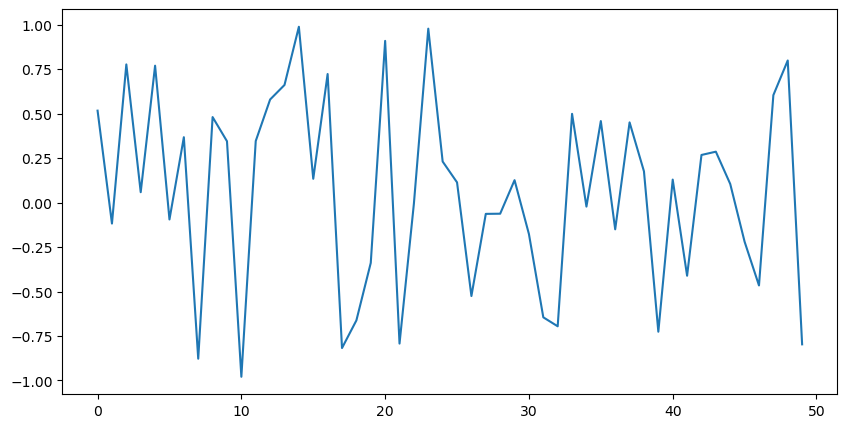

In [28]:
# set noise input
# 长度为500，分布在（-1,1）之间的任意取值
noise_input = np.random.uniform(-1, 1, 500)

plt.figure(figsize=(10, 5))
plt.plot(noise_input[0:50])
plt.show()

# 

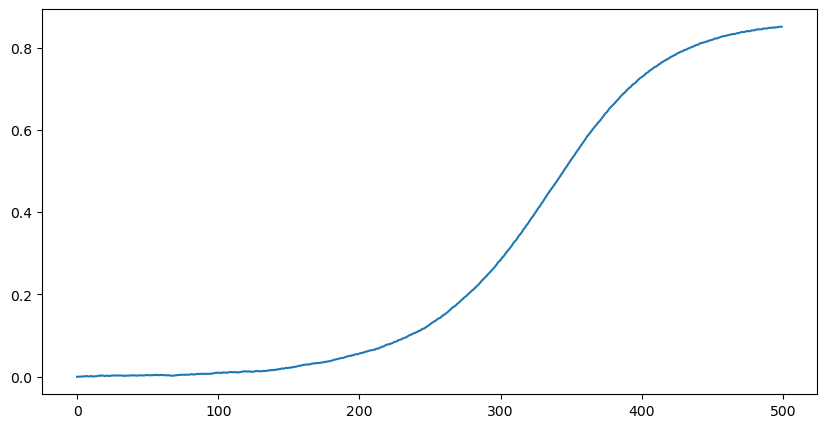

In [31]:
# set Reservoirs and RunSpncs

spn_bestCQ = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        27.5044435911311,
        restart=True
    )

params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=1, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 1}
        )
# spn_bestMC = spnc_anisotropy(
#         0.4,
#         90,
#         0,
#         45,
#         50,
#         restart=True
#     )
# params_bestMC = ReservoirParams(
#             h=0.4, m0=0.008, Nvirt=200, beta_prime=	50.0,
#             params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 200}
#         )  
transform_bestCQ =  spn_bestCQ.gen_signal_slow_delayed_feedback
# 修正输入形状为二维 (N, 1)，以避免matmul维度不匹配
S_bestCQ = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestCQ.Nvirt, params_bestCQ.m0, transform_bestCQ, params_bestCQ.params, fixed_mask=True, seed_mask=1234)

# transform_bestMC =  spn_bestMC.gen_signal_slow_delayed_feedback
# S_bestMC = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestMC.Nvirt, params_bestMC.m0, transform_bestMC, params_bestMC.params, fixed_mask=True, seed_mask=1234)

plt.figure(figsize=(10, 5))
plt.plot(S_bestCQ)
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(S_bestMC)
# plt.show()


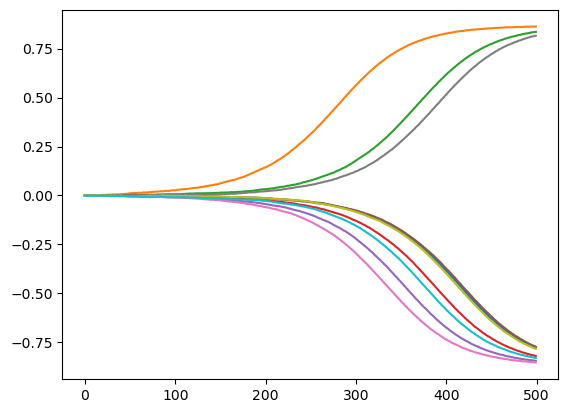

In [39]:
loops = 10

for i in range(loops):
    noise_input = np.random.uniform(-1, 1, 500)
    spn_bestCQ = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        27.5044435911311,
        restart=True
    )

    params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=1, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 1}
        )
    transform_bestCQ =  spn_bestCQ.gen_signal_slow_delayed_feedback
    S_bestCQ = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestCQ.Nvirt, params_bestCQ.m0, transform_bestCQ, params_bestCQ.params, fixed_mask=True, seed_mask=1234)
    plt.plot(S_bestCQ[:,0])
plt.show()

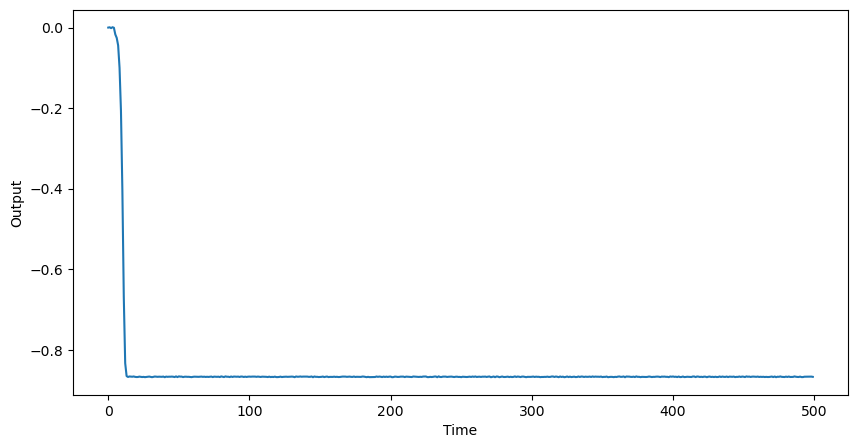

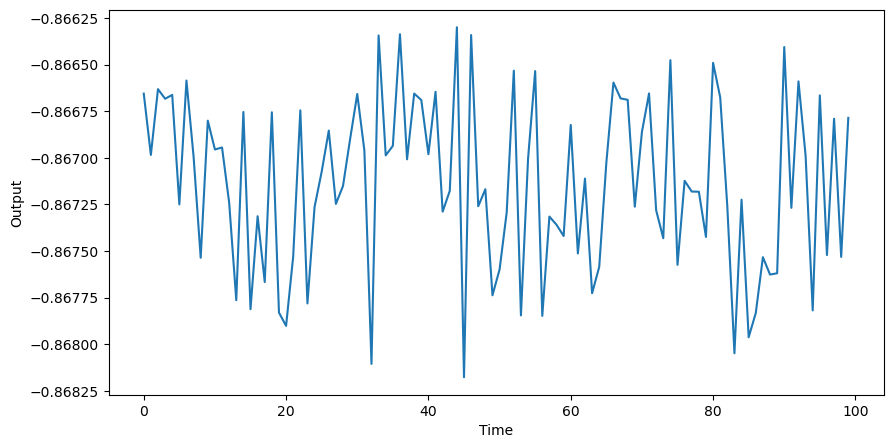

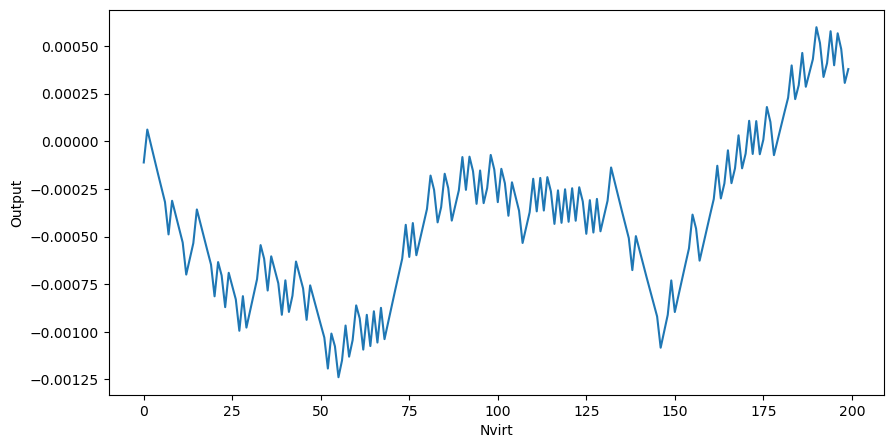

rms_bestCQ 0.8671360500548368
std_bestCQ 0.0004611898760407917
RMS_mean_bestCQ 0.0005046383528568555


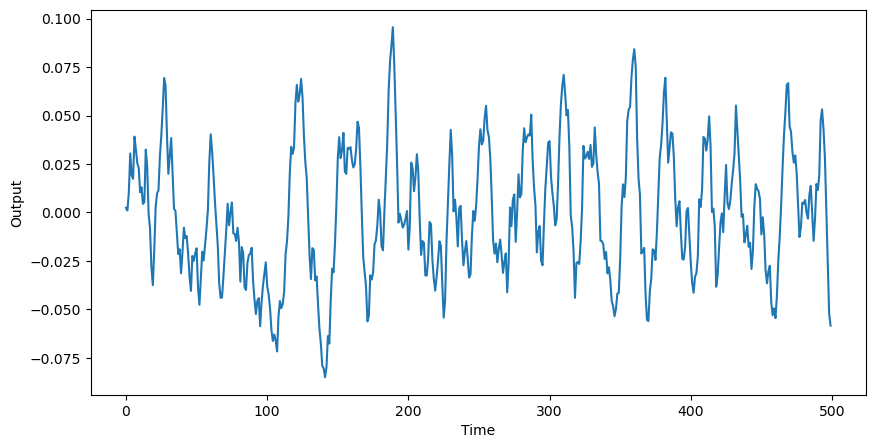

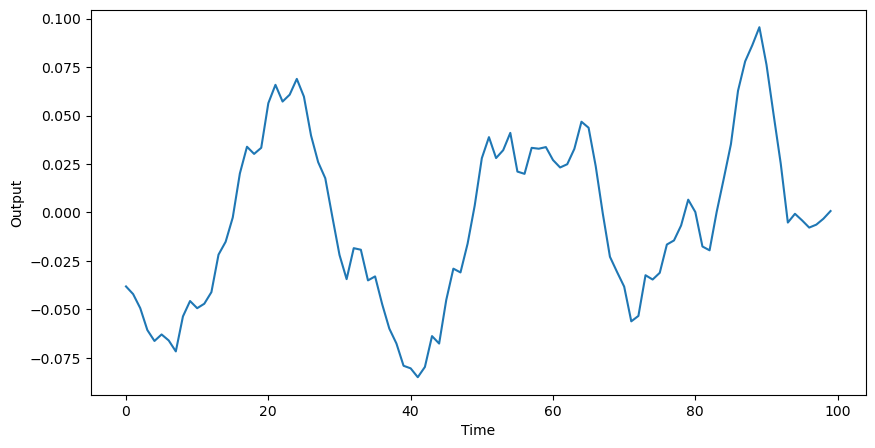

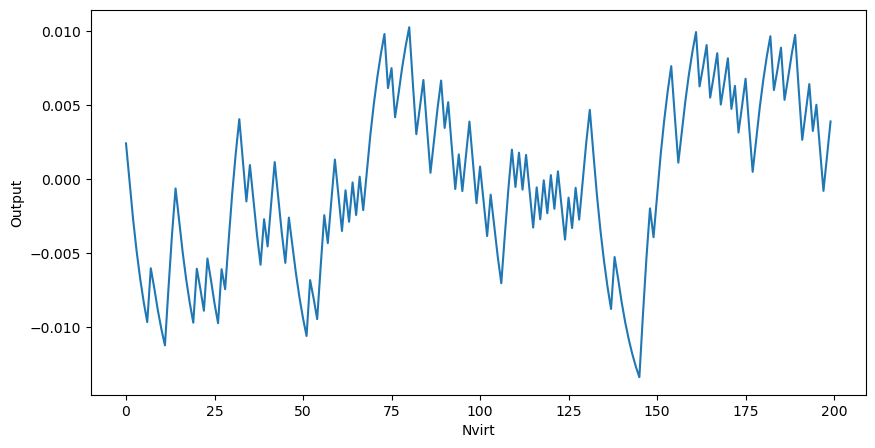

rms_bestMC 0.04365134559877806
std_bestMC 0.04345757119388534
RMS_mean_bestMC 0.03324654982714721


In [41]:
plt.figure(figsize=(10, 5))
plt.plot(S_bestCQ[:,0])
plt.xlabel('Time')
plt.ylabel('Output')

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(S_bestCQ[100:200,0])
plt.xlabel('Time')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(S_bestCQ[0,:])
plt.xlabel('Nvirt')
plt.ylabel('Output')
plt.show()

# 计算S_bestCQ的RMS
rms_bestCQ = np.sqrt(np.mean(S_bestCQ[100:200,0]**2))
print('rms_bestCQ',rms_bestCQ)

# 计算S_bestCQ的标准差
std_bestCQ = np.std(S_bestCQ[100:200,0])
print('std_bestCQ',std_bestCQ)

# 计算S_bestCQ的中心化后的RMS
RMS_mean_bestCQ = np.sqrt(np.mean((S_bestCQ[100:500,0]-np.mean(S_bestCQ[100:500,0]))**2))
print('RMS_mean_bestCQ',RMS_mean_bestCQ)

plt.figure(figsize=(10, 5))
plt.plot(S_bestMC[:,0])
plt.xlabel('Time')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(S_bestMC[100:200,0])
plt.xlabel('Time')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(S_bestMC[0,:])
plt.xlabel('Nvirt')
plt.ylabel('Output')
plt.show()

# 计算S_bestMC的RMS
rms_bestMC = np.sqrt(np.mean(S_bestMC[100:200,0]**2))
print('rms_bestMC',rms_bestMC)

# 计算S_bestMC的标准差
std_bestMC = np.std(S_bestMC[100:200,0])
print('std_bestMC',std_bestMC)

# 计算S_bestMC的中心化后的RMS
RMS_mean_bestMC = np.sqrt(np.mean((S_bestMC[:,0]-np.mean(S_bestMC[:,0]))**2))
print('RMS_mean_bestMC',RMS_mean_bestMC)

In [9]:
# 让我们看看narma10中的表现
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=30, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 30}
        )

results = eva_narma10(params_bestCQ, Ntrain=2000, Ntest=1000, seed_NARMA=1234, return_all=True)

Samples for training:  2000
Samples for test:  1000
Nin = 1 , Nout =  2000 , Nvirt =  30
the mask [[ 0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [ 0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [ 0.00636114]
 [ 0.00636114]
 [ 0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [ 0.00636114]
 [-0.00636114]
 [-0.00636114]
 [ 0.00636114]
 [-0.00636114]
 [-0.00636114]
 [-0.00636114]
 [ 0.00636114]
 [-0.00636114]
 [ 0.00636114]]
Seed Training: 1234
len(x_train): 2000
error with zero =  0.012793087098572142
l= 4.5399929762484854e-05 0.012388958640762308
lambda=4.5399929762484854e-05: MSE=0.012388958640762308
Current weights: [[-2.82628529]
 [-7.37770126]
 [-3.60071661]
 [-3.21073555]
 [-1.61769909]
 [-0.68340206]
 [ 1.38734492]
 [ 2.44460727]
 [ 0.76703076]
 [ 2.21075537]
 [ 3.35354605]
 [ 4.82471534]
 [ 2.05034239]
 [ 1.8100798 ]
 [ 3.81430185]
 [ 0.32182408]
 [ 0.8015877

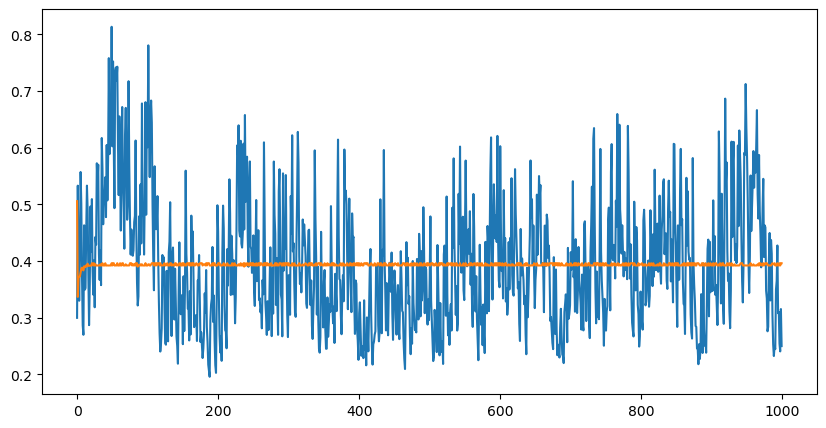

In [10]:
# 打印下results

plt.figure(figsize=(10, 5))
plt.plot(results['y_test'])
plt.plot(results['pred'])
plt.show()

input max [0.49991365]
input min [0.00022035]


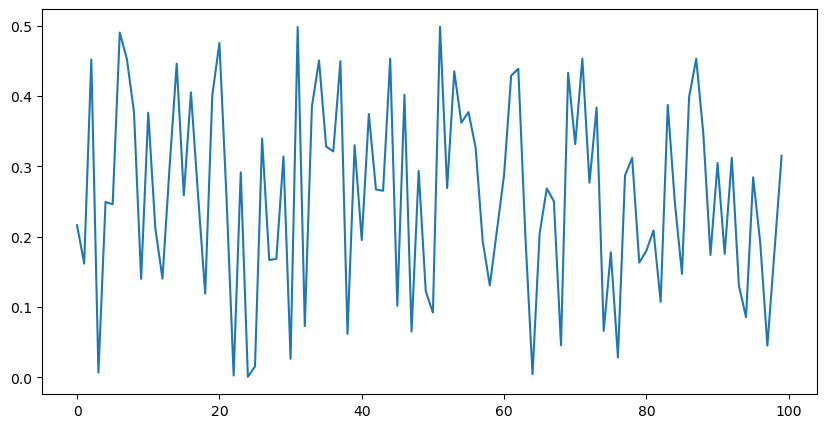

In [18]:
# 看看input
print('input max',max(results['x_train']))
print('input min',min(results['x_train']))
plt.figure(figsize=(10, 5))
plt.plot(results['x_train'][100:200])
plt.show()

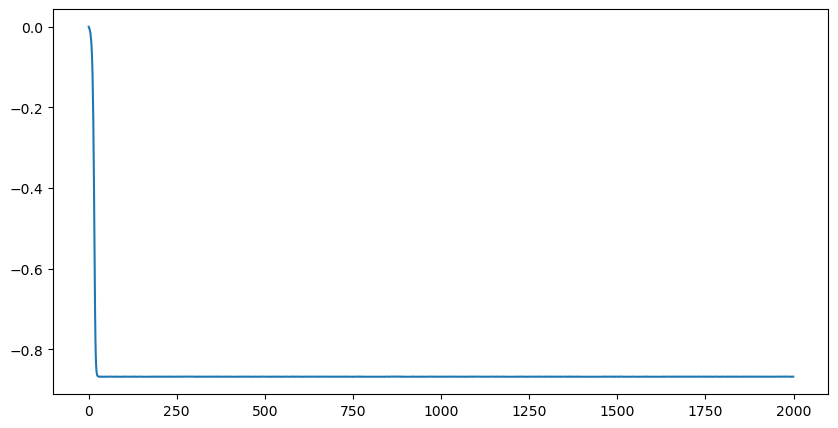

(2000,)


In [31]:
# 看看training阶段的output
plt.figure(figsize=(10, 5))
plt.plot(results['S_train'][:,0])
plt.show()

print(np.shape(results['S_train'][:,0]))




(30, 1)


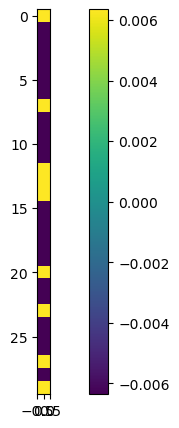

(31, 1)


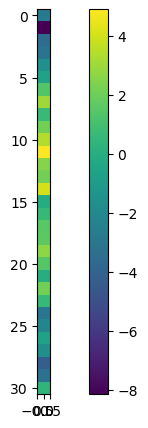

In [33]:
# 看看mask

print(np.shape(results['M']))
# 看看W

plt.figure(figsize=(10, 5))
plt.imshow(results['M'])
plt.colorbar()
plt.show()

print(np.shape(results['W']))

plt.figure(figsize=(10, 5))
plt.imshow(results['W'])
plt.colorbar()
plt.show()

作为对比，我们看看bestMC的表现

In [34]:
# 让我们看看narma10中的表现
params_bestMC = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=30, beta_prime=	50.0,
            params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 30}
)

results_MC = eva_narma10(params_bestMC, Ntrain=2000, Ntest=1000, seed_NARMA=1234, return_all=True)

Samples for training:  2000
Samples for test:  1000
Nin = 1 , Nout =  2000 , Nvirt =  30
the mask [[ 0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [ 0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [ 0.008]
 [ 0.008]
 [ 0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [ 0.008]
 [-0.008]
 [-0.008]
 [ 0.008]
 [-0.008]
 [-0.008]
 [-0.008]
 [ 0.008]
 [-0.008]
 [ 0.008]]
Seed Training: 1234
len(x_train): 2000
error with zero =  0.0068289572051185386
l= 4.5399929762484854e-05 0.0071086974261330375
lambda=4.5399929762484854e-05: MSE=0.0071086974261330375
Current weights: [[ 1.17994485e+01]
 [ 8.08406538e+00]
 [-1.11324068e+00]
 [-4.83377831e-01]
 [ 3.06204086e-01]
 [ 2.79461431e+00]
 [ 6.88212404e-01]
 [-1.16511590e+01]
 [-6.05424056e+00]
 [ 4.73747205e+00]
 [ 1.15082391e+01]
 [ 2.16065902e+01]
 [ 1.80253748e+01]
 [ 8.80817802e+00]
 [-1.40063860e+01]
 [-9.13305642e+00]
 [-4.28355047e+00]
 [-2.61325002e+00]
 [-4.04534415e+00]
 [-4.50730822e+00]
 [-1.50120463e+01]


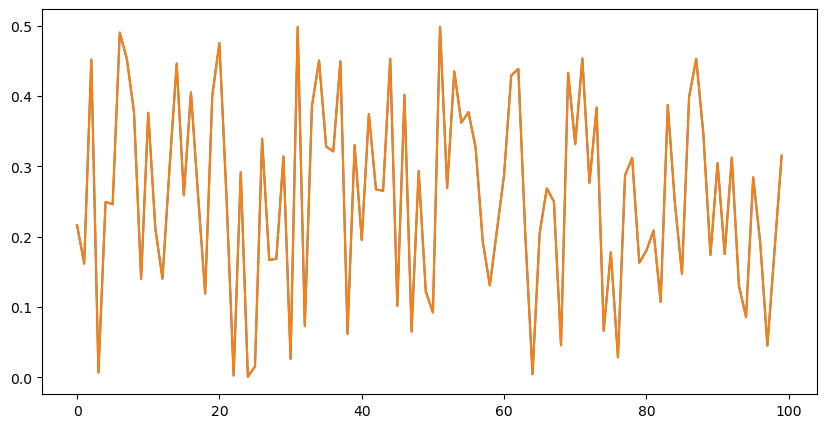

In [35]:
#对比下input
plt.figure(figsize=(10, 5))
plt.plot(results_MC['x_train'][100:200])
plt.plot(results['x_train'][100:200])
plt.show()

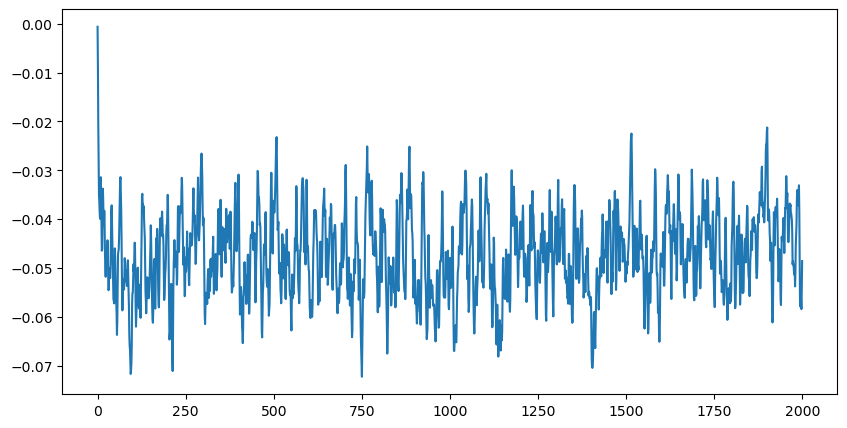

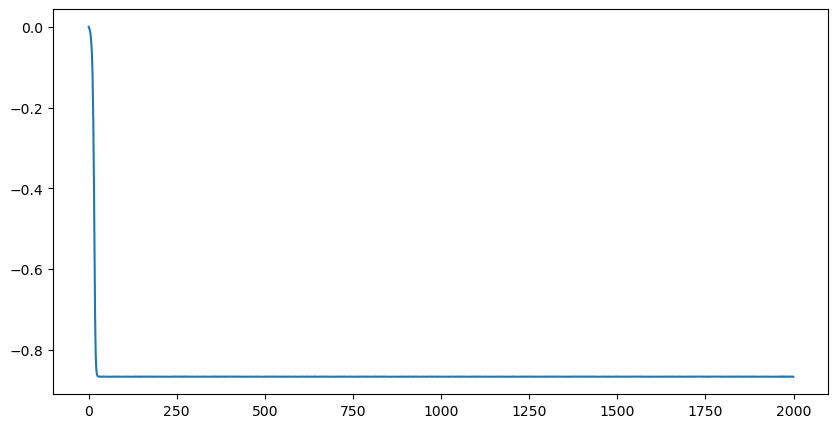

In [38]:
# 对比下transformed singal
plt.figure(figsize=(10, 5))
plt.plot(results_MC['S_train'][:,1])
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results['S_train'][:,1])
plt.show()

In [ ]:
# 对比下lambda
# bestCQ:Final chosen lambda: 4.5399929762484854e-05 Final weights stats: mean=0.0114, std=2.8031, norm=15.6074 Final training MSE with chosen lambda: 0.01235133404554999

# bestMC:Final chosen lambda: 0.0, Final weights stats: mean=-0.7019, std=129.4881, norm=720.9699,Final training MSE with chosen lambda: 0.006595238141436738


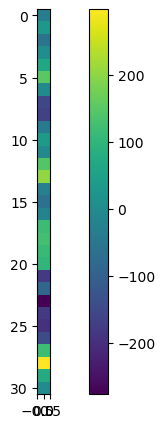

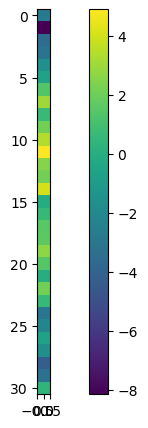

In [39]:
#对比下W
plt.figure(figsize=(10, 5))
plt.imshow(results_MC['W'])
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(results['W'])
plt.colorbar()
plt.show()

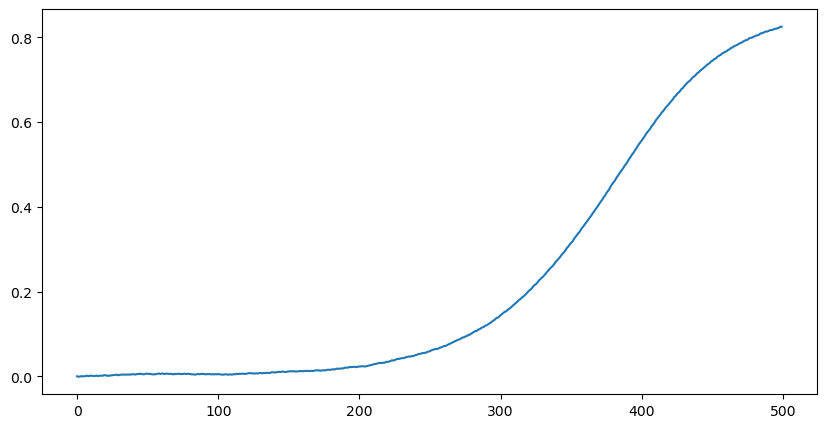

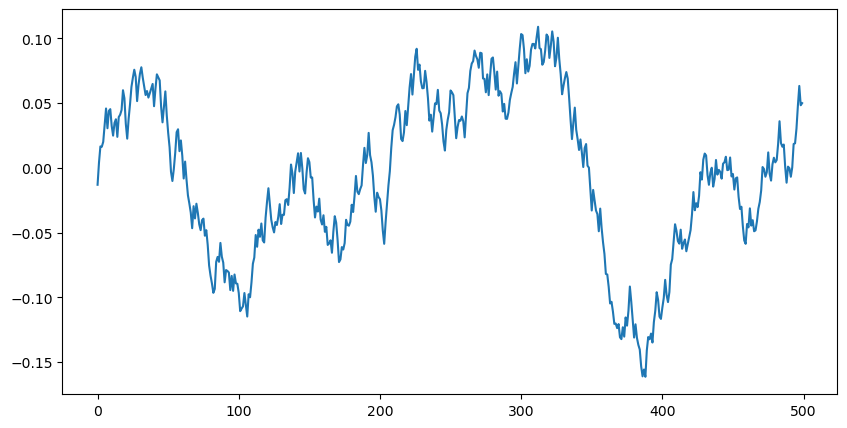

In [79]:
# 使用Nv=1可能是一个更加合适的选择。

# 设置input为随机噪声
noise_input = np.random.uniform(-1, 1, 500)

# 设置Nv=1
# set Reservoirs and RunSpncs

spn_bestCQ_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        27.5044435911311,
        restart=True
    )

params_bestCQ_Nv1 = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=1, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 1}
        )
spn_bestMC_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
params_bestMC_Nv1 = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=1, beta_prime=	50.0,
            params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 1}
        )  
transform_bestCQ_Nv1 =  spn_bestCQ_Nv1.gen_signal_slow_delayed_feedback
# 修正输入形状为二维 (N, 1)，以避免matmul维度不匹配
S_bestCQ_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestCQ_Nv1.Nvirt, params_bestCQ_Nv1.m0, transform_bestCQ_Nv1, params_bestCQ_Nv1.params, fixed_mask=True, seed_mask=1234)

transform_bestMC_Nv1 =  spn_bestMC_Nv1.gen_signal_slow_delayed_feedback
S_bestMC_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestMC_Nv1.Nvirt, params_bestMC_Nv1.m0, transform_bestMC_Nv1, params_bestMC_Nv1.params, fixed_mask=True, seed_mask=1234)

plt.figure(figsize=(10, 5))
plt.plot(S_bestCQ_Nv1)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(S_bestMC_Nv1)
plt.show()

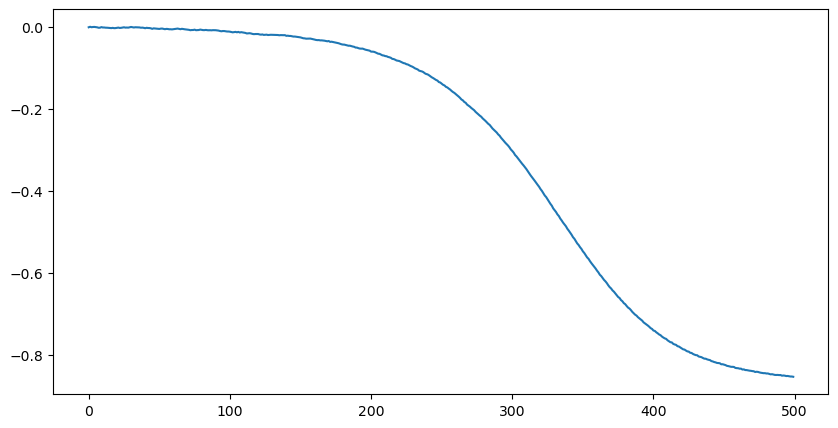

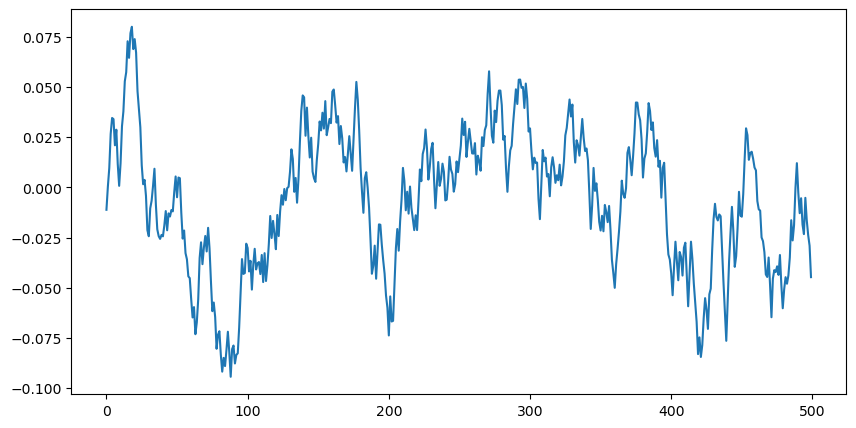

In [86]:
# 似乎看起来噪声的随机性是影响储层输出，让我们看看遍历多次下的结果

# 设置遍历次数
loop = 1

plt.figure(figsize=(10, 5))

for i in range(loop):
    noise_input = np.random.uniform(-1, 1, 500)
    spn_bestCQ_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        27.5044435911311,
        restart=True
    )
    transform_bestCQ_Nv1 =  spn_bestCQ_Nv1.gen_signal_slow_delayed_feedback
    S_bestCQ_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestCQ_Nv1.Nvirt, params_bestCQ_Nv1.m0, transform_bestCQ_Nv1, params_bestCQ_Nv1.params, fixed_mask=True, seed_mask=1234)
    plt.plot(S_bestCQ_Nv1)
plt.show()

# 对比bestMC
plt.figure(figsize=(10, 5))

for i in range(loop):
    noise_input = np.random.uniform(-1, 1, 500)
    spn_bestMC_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
    transform_bestMC_Nv1 =  spn_bestMC_Nv1.gen_signal_slow_delayed_feedback
    S_bestMC_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_bestMC_Nv1.Nvirt, params_bestMC_Nv1.m0, transform_bestMC_Nv1, params_bestMC_Nv1.params, fixed_mask=True, seed_mask=1234)
    plt.plot(S_bestMC_Nv1)
plt.show()

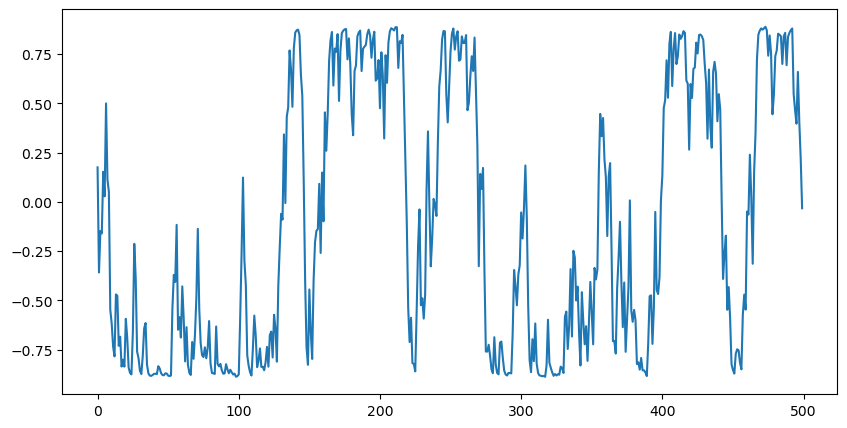

In [ ]:
# 对比一个nrmse=1储层
plt.figure(figsize=(10, 5))

for i in range(loop):
    noise_input = np.random.uniform(-1, 1, 500)
    spn_normal_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
    params_normal_Nv1 = ReservoirParams(
            h=0.4, m0=0.1825634100095717, Nvirt=1, beta_prime=	50.0,
            params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 1}
        )
    transform_normal_Nv1 =  spn_normal_Nv1.gen_signal_slow_delayed_feedback
    S_normal_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_normal_Nv1.Nvirt, params_normal_Nv1.m0, transform_normal_Nv1, params_normal_Nv1.params, fixed_mask=True, seed_mask=1234)
    plt.plot(S_normal_Nv1)
plt.show()

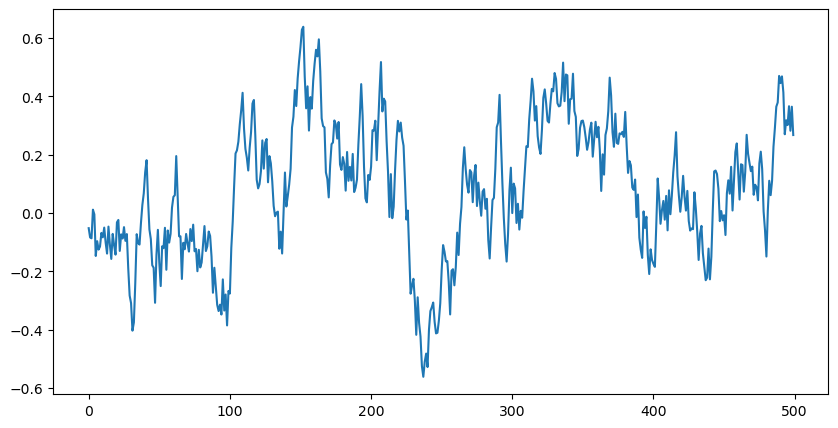

In [88]:
# 对比一个nrmse=0.6储层
plt.figure(figsize=(10, 5))

for i in range(loop):
    noise_input = np.random.uniform(-1, 1, 500)
    spn_normal_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
    params_normal_Nv1 = ReservoirParams(
            h=0.4, m0=0.0516554082018051, Nvirt=1, beta_prime=	50.0,
            params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 1}
        )
    transform_normal_Nv1 =  spn_normal_Nv1.gen_signal_slow_delayed_feedback
    S_normal_Nv1 = RunSpnc(noise_input.reshape(-1, 1), 1, 1, params_normal_Nv1.Nvirt, params_normal_Nv1.m0, transform_normal_Nv1, params_normal_Nv1.params, fixed_mask=True, seed_mask=1234)
    plt.plot(S_normal_Nv1)
plt.show()

尝试下不同类型的输入看看能否区分？

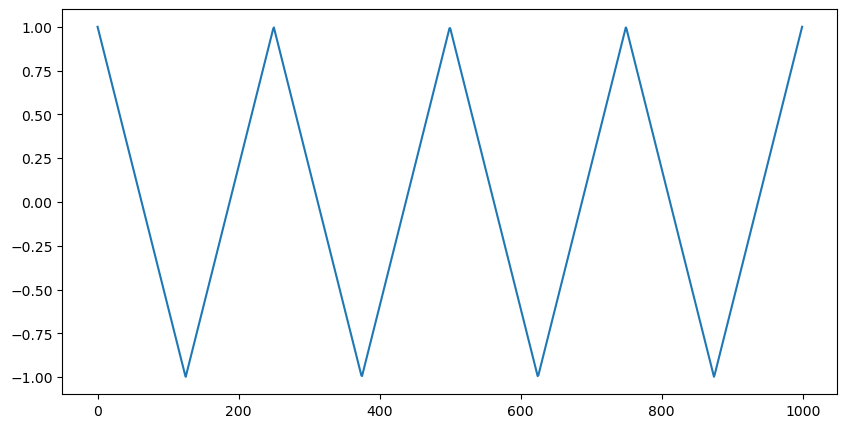

In [ ]:
# 三角波
T = 1000; cycles = 4
t = np.linspace(0, 1, T)
tri = 2*np.abs(2*(t*cycles % 1)-1)-1
plt.figure(figsize=(10, 5))
plt.plot(tri)
plt.show()

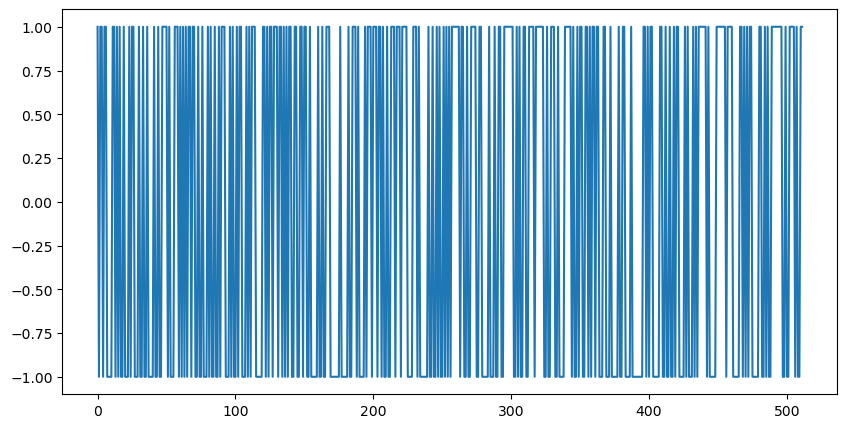

In [93]:
# PRBS
L = 512
prbs = 2*(np.random.randint(0,2,L))-1
plt.figure(figsize=(10, 5))
plt.plot(prbs)
plt.show()


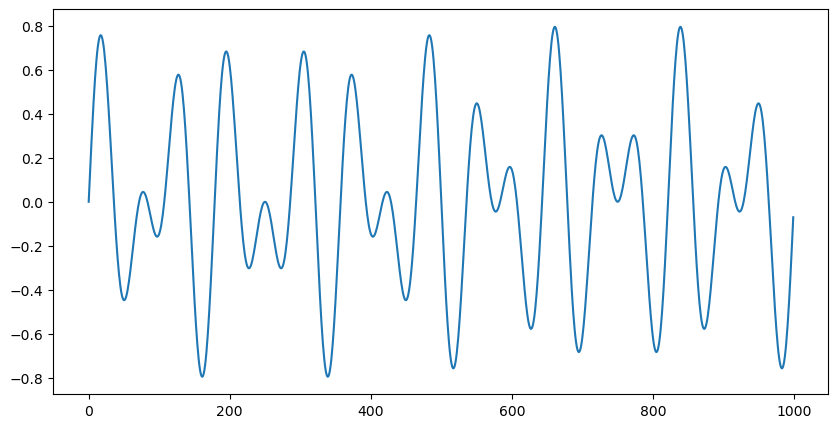

In [95]:
t = np.arange(T)/T
sig = 0.4*np.sin(2*np.pi*11*t) + 0.4*np.sin(2*np.pi*17*t)
plt.figure(figsize=(10, 5))
plt.plot(sig)
plt.show()


In [113]:
def filter(u,y,period):
    
    y = np.ravel(np.asarray(y))
    u = np.ravel(np.asarray(u))
    assert len(y) == len(u)

    # Sat
    ymin, ymax = y.min(), y.max(); R = max(1e-12, ymax - ymin)
    Sat = np.mean((y <= ymin + 0.1*R) | (y >= ymax - 0.1*R))
    # Drift
    t = np.arange(len(y))
    Drift = 0.0 if y.std() == 0 else float(abs(np.corrcoef(t, y)[0,1]))
    # Lag
    y0 = y - y.mean(); u0 = u - u.mean()
    L = np.argmax(np.correlate(y0, u0, mode='full')) - (len(y)-1)
    LagRatio = abs(L) / float(period)
    # THD（简单版；如需更准可按前文加入去趋势/窗/零填充）
    Yf = np.fft.rfft(y0)
    freqs = np.fft.rfftfreq(len(y), d=1)
    f0 = 1.0/float(period)
    k1 = np.argmin(abs(freqs - f0))
    A1 = abs(Yf[k1]); Ak = np.abs(Yf); 
    Ak[[0, k1]] = 0
    THD = float(np.linalg.norm(Ak) / (A1 + 1e-12))

    # 轻门槛
    hard_pass = (Drift <= 0.60) and (0.01 <= LagRatio <= 0.60) and (THD <= 0.80)

    # 加权分
    z_sat   = max(0.0, 1.0 - Sat)
    z_drift = max(0.0, 1.0 - Drift)
    z_lag   = max(0.0, 1.0 - abs(LagRatio - 0.2)/0.2)
    z_thd   = max(0.0, 1.0 - THD/0.8)

    score = 0.35*z_sat + 0.25*z_drift + 0.20*z_lag + 0.20*z_thd
    pass_flag = hard_pass and (score >= 0.55)

    info = dict(Sat=Sat, Drift=Drift, LagRatio=LagRatio, THD=THD,
                z_sat=z_sat, z_drift=z_drift, z_lag=z_lag, z_thd=z_thd)
    return pass_flag, score, info

In [114]:
# 设置Nv=1
# set Reservoirs and RunSpncs
def run_spnc(signal):
    spn_bestCQ_Nv1 = spnc_anisotropy(
            0.4,
            90,
            0,
            45,
            27.5044435911311,
            restart=True
        )

    params_bestCQ_Nv1 = ReservoirParams(
                h=0.4, m0=0.00636114267244565, Nvirt=1, beta_prime=27.5044435911311,
                params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 1}
            )
    transform_bestCQ_Nv1 =  spn_bestCQ_Nv1.gen_signal_slow_delayed_feedback

    S_bestCQ_Nv1 = RunSpnc(signal.reshape(-1, 1), 1, 1, params_bestCQ_Nv1.Nvirt, params_bestCQ_Nv1.m0, transform_bestCQ_Nv1, params_bestCQ_Nv1.params, fixed_mask=True, seed_mask=1234)



    spn_bestMC_Nv1 = spnc_anisotropy(
            0.4,
            90,
            0,
            45,
            50,
            restart=True
        )
    params_bestMC_Nv1 = ReservoirParams(
                h=0.4, m0=0.008, Nvirt=1, beta_prime=	50.0,
                params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 1}
            )  

    transform_bestMC_Nv1 =  spn_bestMC_Nv1.gen_signal_slow_delayed_feedback
    S_bestMC_Nv1 = RunSpnc(signal.reshape(-1, 1), 1, 1, params_bestMC_Nv1.Nvirt, params_bestMC_Nv1.m0, transform_bestMC_Nv1, params_bestMC_Nv1.params, fixed_mask=True, seed_mask=1234)

    spn_normal_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
    params_normal_Nv1 = ReservoirParams(
        h=0.4, m0=0.1825634100095717, Nvirt=1, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 1}
    )
    transform_normal_Nv1 =  spn_normal_Nv1.gen_signal_slow_delayed_feedback
    S_normal_Nv1 = RunSpnc(signal.reshape(-1, 1), 1, 1, params_normal_Nv1.Nvirt, params_normal_Nv1.m0, transform_normal_Nv1, params_normal_Nv1.params, fixed_mask=True, seed_mask=1234)


    spn_good_Nv1 = spnc_anisotropy(
        0.4,
        90,
        0,
        45,
        50,
        restart=True
    )
    params_good_Nv1 = ReservoirParams(
            h=0.4, m0=0.0516554082018051, Nvirt=1, beta_prime=	50.0,
            params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 1}
        )
    transform_good_Nv1 =  spn_good_Nv1.gen_signal_slow_delayed_feedback
    S_good_Nv1 = RunSpnc(signal.reshape(-1, 1), 1, 1, params_good_Nv1.Nvirt, params_good_Nv1.m0, transform_good_Nv1, params_good_Nv1.params, fixed_mask=True, seed_mask=1234)


    plt.figure(figsize=(10, 5))
    plt.plot(S_bestCQ_Nv1)
    plt.title('bestCQ')
    plt.show()

    dict_bestCQ = {}
    dict_bestMC = {}
    dict_normal = {}
    dict_good = {}

    pass_flag, score, info = filter(signal, S_bestCQ_Nv1, 250)
    dict_bestCQ['pass_flag'] = pass_flag
    dict_bestCQ['score'] = score
    dict_bestCQ['info'] = info
    print('bestCQ',pass_flag, score)

    plt.figure(figsize=(10, 5))
    plt.plot(S_bestMC_Nv1)
    plt.title('bestMC')
    plt.show()

    pass_flag, score, info = filter(signal, S_bestMC_Nv1, 250)
    dict_bestMC['pass_flag'] = pass_flag
    dict_bestMC['score'] = score
    dict_bestMC['info'] = info
    print('bestMC',pass_flag, score)
    

    plt.figure(figsize=(10, 5))
    plt.plot(S_good_Nv1)
    plt.title('good')
    plt.show()

    pass_flag, score, info = filter(signal, S_good_Nv1, 250)
    dict_good['pass_flag'] = pass_flag
    dict_good['score'] = score
    dict_good['info'] = info
    print('good',pass_flag, score)

    plt.figure(figsize=(10, 5))
    plt.plot(S_normal_Nv1)
    plt.title('normal')
    plt.show()

    pass_flag, score, info = filter(signal, S_normal_Nv1, 250)
    dict_normal['pass_flag'] = pass_flag
    dict_normal['score'] = score
    dict_normal['info'] = info
    print('normal',pass_flag, score)
    return dict_bestCQ, dict_bestMC, dict_normal, dict_good



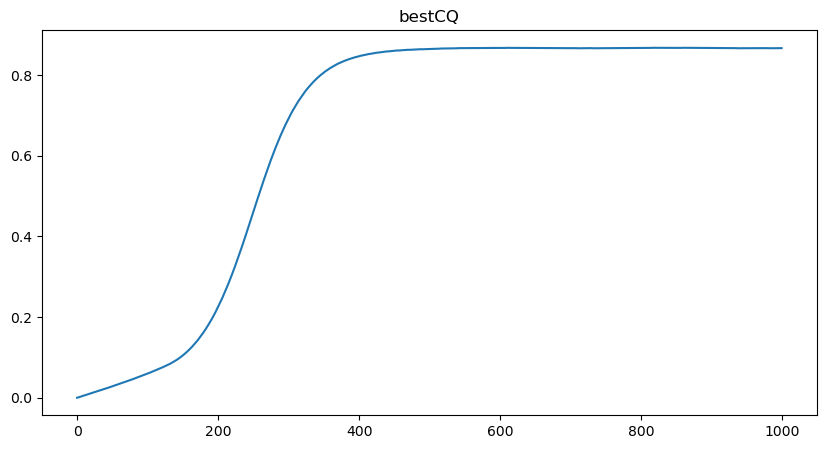

bestCQ False 0.11443068394032059


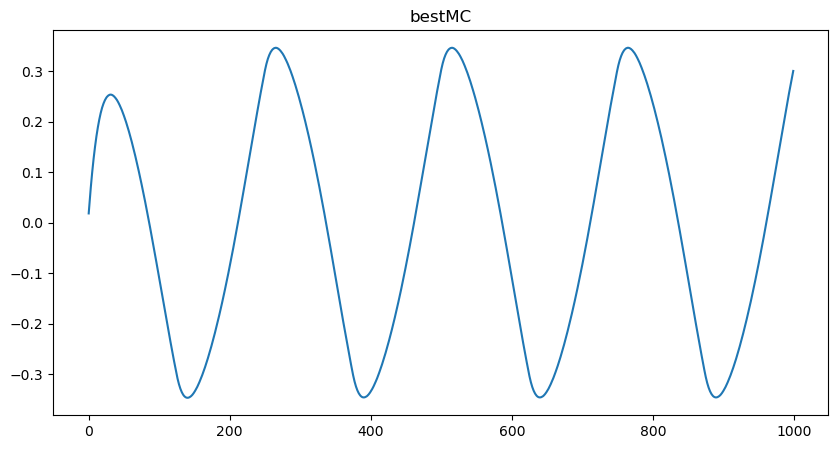

bestMC True 0.7198944639290984


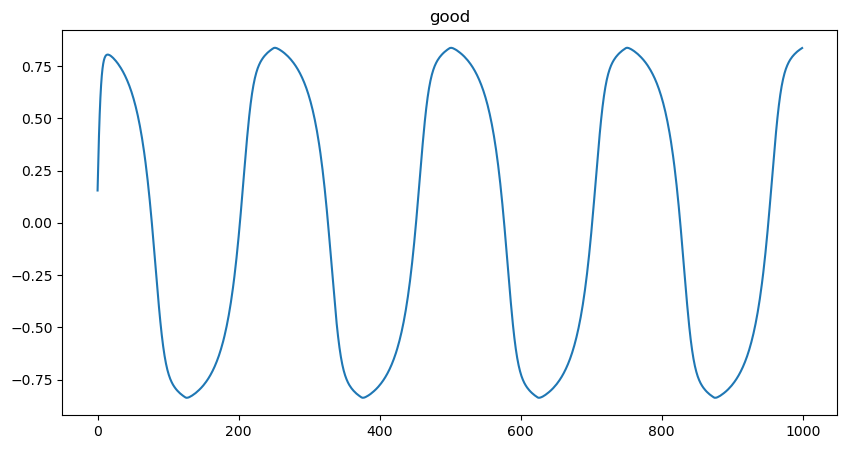

good True 0.5820050312514766


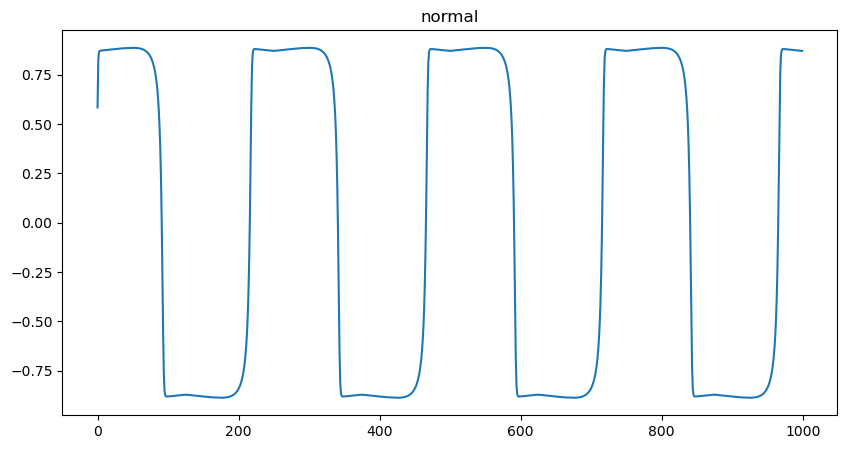

normal False 0.45337221480683293


In [115]:
# 测试tri
dict_bestCQ, dict_bestMC, dict_normal, dict_good=run_spnc(tri)

In [112]:
# 打印bestMC中的dict来看看
print(dict_good)

{'pass_flag': np.False_, 'score': np.float64(0.05546624124034164), 'info': {'Sat': np.float64(0.567), 'Drift': 0.04113880718707221, 'LagRatio': np.float64(0.032), 'THD': np.float64(0.16504106780702177)}}


In [120]:
def run_spnc_experiment(tri, augment_dict, plot = False):
    """
    运行SPNC实验的封装函数
    
    参数:
    tri: 输入信号
    h: spn参数h (默认0.4)
    m0: ReservoirParams参数m0 (默认0.008)
    Nvirt: ReservoirParams参数Nvirt (默认1)
    beta_prime: ReservoirParams参数beta_prime (默认20.0)
    theta: spn参数theta (默认0.145090117811982)
    gamma: spn参数gamma (默认0.09907866306038172)
    spn_beta: spn中的beta参数 (默认20)
    augment_dict: 包含augment参数的字典，如果提供则优先使用字典中的值 (可选)
                 支持的参数: h, m0, Nvirt, beta_prime, theta, gamma, spn_beta
    
    返回:
    result: 包含pass_flag, score, info的字典
    """
    
    # 如果提供了augment_dict，从中提取参数值，否则使用函数参数的默认值
    if augment_dict is not None:
        trial = augment_dict.get('trial',trial)
        m0 = augment_dict.get('m0', m0)
        beta_prime = augment_dict.get('beta_prime', beta_prime)
        theta = augment_dict.get('theta', theta)
        gamma = augment_dict.get('gamma', gamma)
    
    # 创建spn对象
    spn = spnc_anisotropy(0.4,90,0,45,beta_prime,restart=True)

    # 创建ReservoirParams对象
    params = ReservoirParams(
        h=0.4, m0=m0, Nvirt=1, beta_prime=beta_prime,
        params={'theta': theta, 'gamma': gamma, 'Nvirt': 1}
    )

    # 生成信号
    transform = spn.gen_signal_slow_delayed_feedback
    S = RunSpnc(tri.reshape(-1, 1), 1, 1, params.Nvirt, params.m0, transform, params.params, fixed_mask=True, seed_mask=1234)

    # 计算结果
    result = {}
    result['pass_flag'], result['score'], result['info'] = filter(tri, S, 250)

    # 判定是否是quiet
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(S)
        plt.title(f'{trial}')
        plt.xlabel("Time")
        plt.ylabel("Signal")
        plt.show()

    return result
